# Временные ряды

# Линейная регрессия
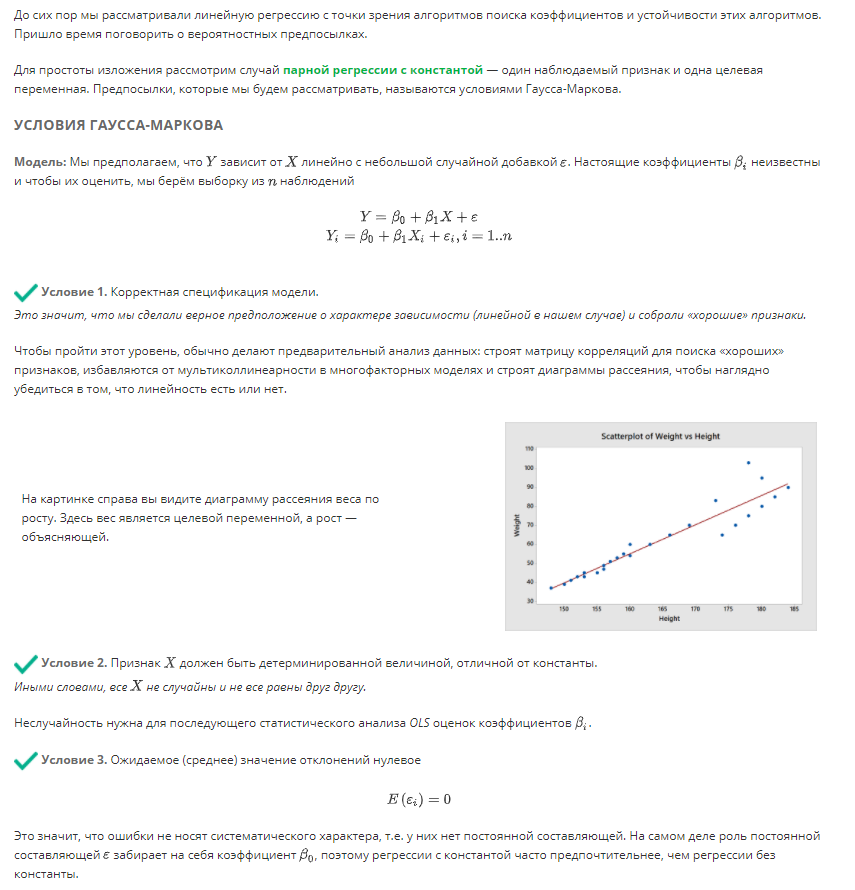

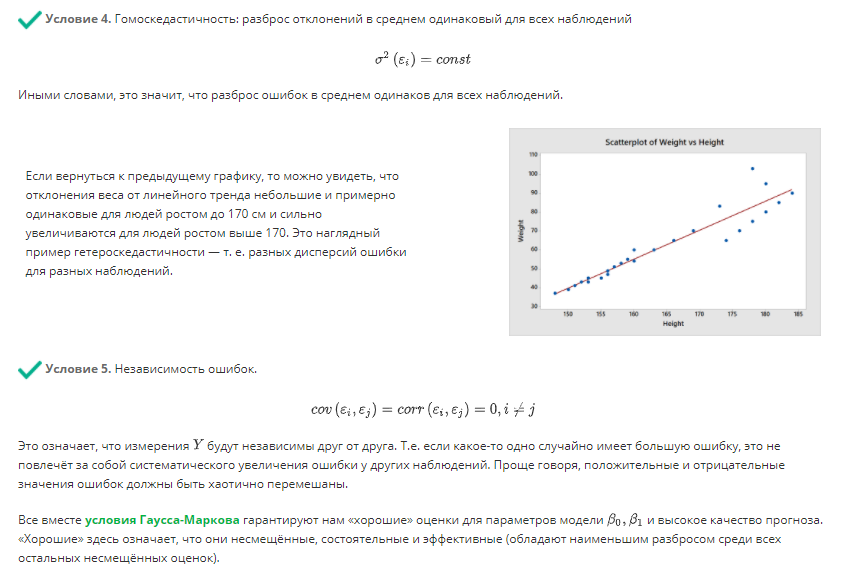

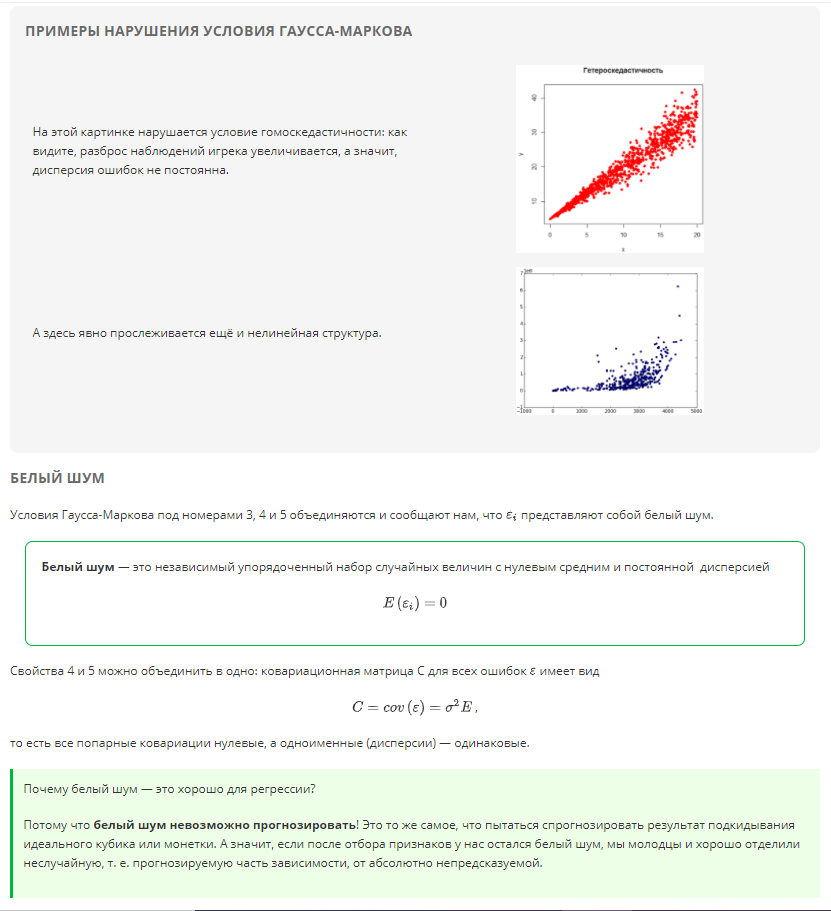

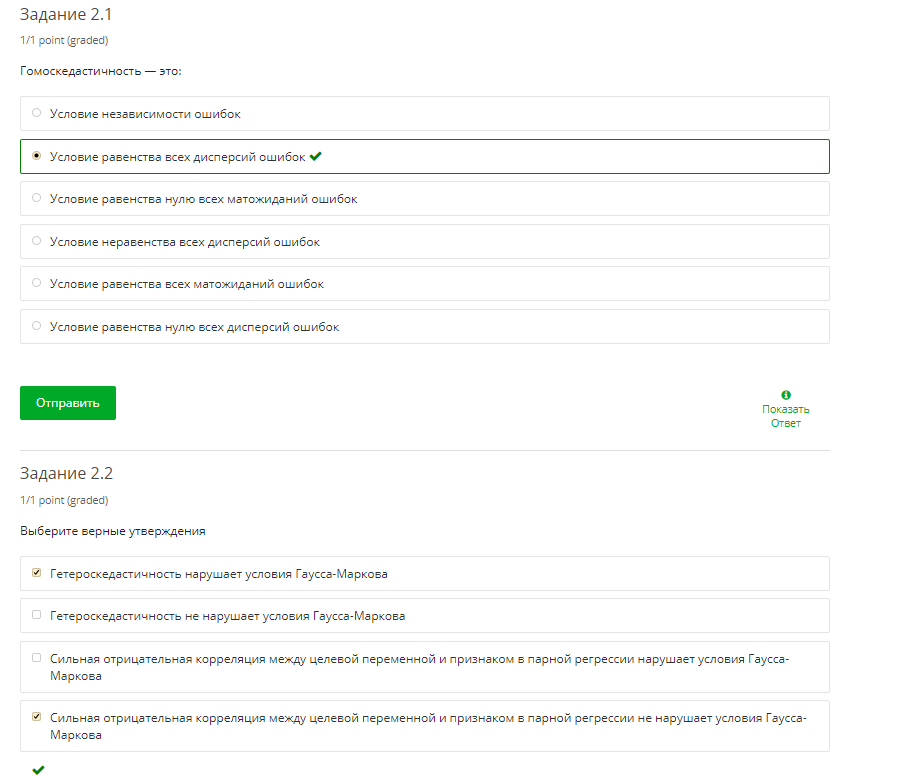

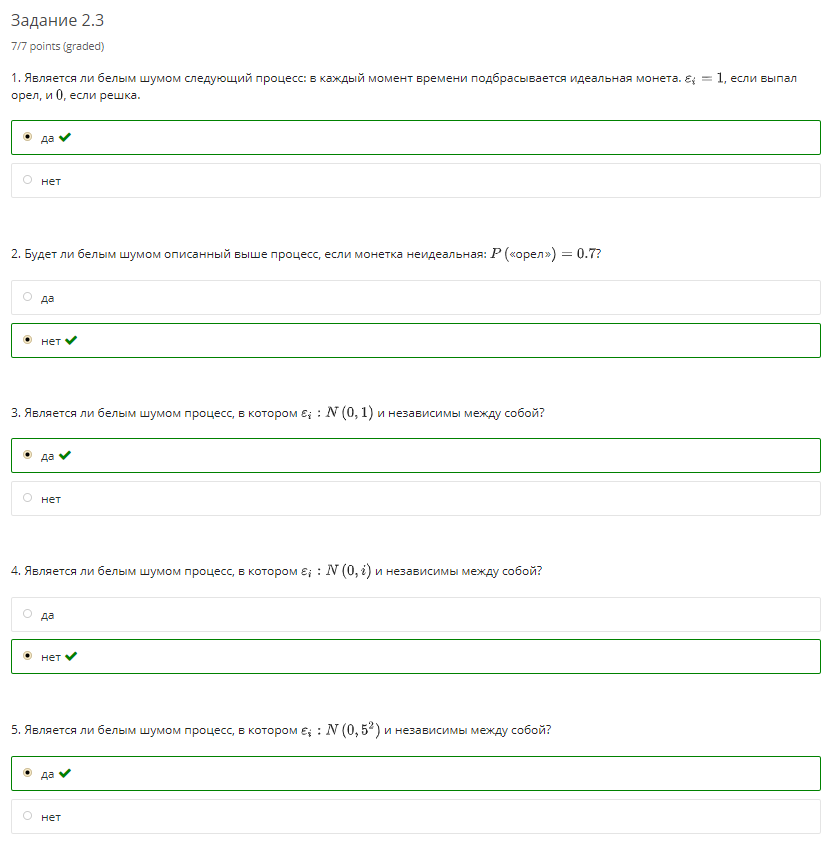

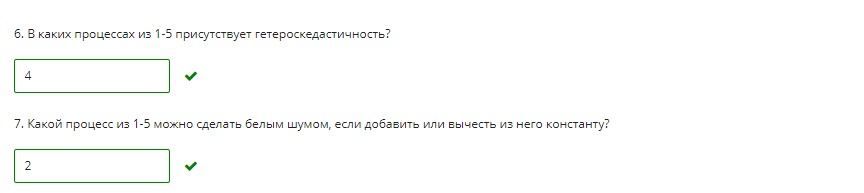

# Практика. Линейная регрессия
Мы познакомимся с генерацией нормального белого шума и посмотрим на практике, как влияет на качество OLS оценок гетероскедастичность

Создадим нормальный белый шум размера N с нулевым средним и единичной дисперсией. Его график совершенно хаотичен

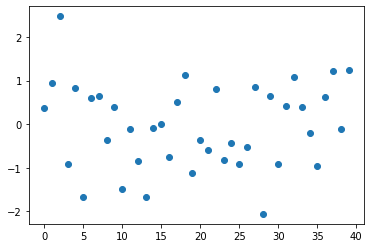

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%matplotlib inline

N = 40
mu = 0
sigma = 1 

eps = np.random.normal(mu, sigma, size=N)

plt.scatter(np.arange(N),eps)

Соединим соседние точки линиями. Это полезно, когда в качестве счетчика выступает время

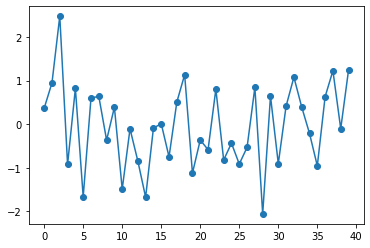

In [25]:
plt.plot(eps)
plt.scatter(np.arange(N),eps)

Сгенерируем данные для регрессии: добавим к линейной функции y=2+x белый шум eps. Диаграмма рассеяния показывает сильный линейный паттерн и в целом ведет себя хорошо

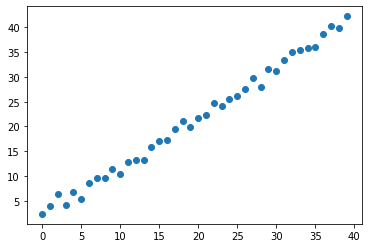

In [27]:
x = np.arange(N)
y = 2 + x + eps
plt.scatter(x,y)

Подготовим данные для обучения классической OLS регрессии. Все условия Гаусса-Маркова выполняются: признак детерминированный (числа от 1 до N), модель хорошая, шум белый. Мы будем пользоваться не lstsq из linalg.numpy, а конструктором LinearRegression() из библиотеки sklearn. Как вы помните, lstsq работает на svd разложении и требует предварительной стандартизации данных в случае существенно разных шкал признаков. LinearRegression() делает стандартизацию сама (впрочем, это можно настроить), однако следует иметь в виду, что алгоритм внутри нее зашит другой, тоже устойчивый к "плохим" данным. Как правило, реализации алгоритмов в sklearn направлены на то, чтобы функция работала быстро. Реализация OLS через теоретическую формулу на практике не применяется из-за плохой вычислительной устойчивости.

In [28]:
# сначала переформатируем данные из одномерных массивов в двумерные, тк этого требует синтаксис LinearRegression() 
# при работе с реальными датасетами делать этого не нужно
x=np.reshape(x,(N,1))
y=np.reshape(y,(N,1))
linreg = linear_model.LinearRegression() 

# обучим модель
linreg.fit(x,y)

# выведем коэффициенты
print(linreg.intercept_,linreg.coef_)

[1.92567307] [[1.00160144]]


Одной из метрик качества модели является r2_score. Это так называемая доля объяснённой дисперсии. Она показывает, какую часть отклонений целевой переменной объясняет модель. Чем выше, тем лучше.

In [29]:
y_pred = linreg.predict(x)
r2_score(y,y_pred)

0.9931819427401662

Теперь давайте испортим немного модель, добавив гетероскедастичность

In [31]:
# создадим функцию, которая будет портить белый шум, добавляя в него неравные дисперсии.
# Кажое следующее значение шума будет в alpha раз выше предыдущего

def hetero_eps(alpha, eps):
    hetero_eps = np.zeros(len(eps))
    for i in range (0,len(eps)):
        hetero_eps[i] = (alpha**i) * eps[i]
    return hetero_eps

Возьмем в качестве alpha 1.5, при этом каждое следующее отклонение будет примерно на 5% больше прыдущего На графике видно, что шум "расползается". Чем больше измерений мы возьмем, тем сильнее будет расплозаться шум, а с ним и весь тренд. В гомоскедастичном случае (для белого шума) чем больше измерений, тем точнее будет настроена регрессия, т.к. никакого расползания там нет

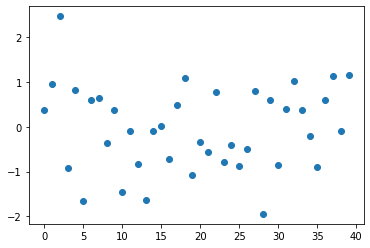

In [32]:
alpha = 0.998
heteps = hetero_eps(alpha,eps) # гетероскедастичный шум
plt.scatter(np.arange(N),heteps)

В модель y = 2 + x добавим гетероскедастичный шум и посмотрим, что будет с регрессией

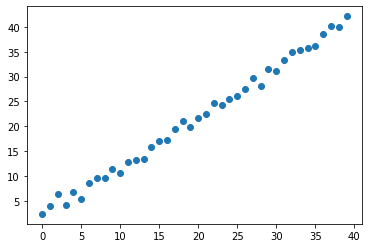

In [33]:
x = np.arange(N)
y = 2 + x + heteps
plt.scatter(x,y) # типичная картинка увеличения дисперсии

In [34]:
# сначала переформатируем данные из одномерных массивов в двумерные, т.к. этого требует синтаксис LinearRegression() 
# при работе с реальными датасетами делать этого не нужно
x=np.reshape(x,(N,1))
y=np.reshape(y,(N,1))
linreg = linear_model.LinearRegression() 

# обучим модель
linreg.fit(x,y)

# выведем коэффициенты
print(linreg.intercept_,linreg.coef_)

[1.93912384] [[1.00097904]]


Как правило, коэффициенты модели с гетероскедастичностю сильнее отличаются от настоящих значений параметров 2 и 1 по сравнению с гомоскедастичным случаем.
Пострадает и r2_score - модель с гетероскедатсичным шумом хуже объясняет изменения y. Прогнозы в такой модели тоже будут менее точные

In [35]:
y_pred = linreg.predict(x)
r2_score(y,y_pred)

0.9936106373040833

Пример внизу показывает, что чем больше гетероскедастичность, тем хуже работает модель

In [36]:
x = np.arange(N)

# увеличим амлитуду шума в 4 раза

y = 2 + x + 4*heteps
x=np.reshape(x,(N,1))
y=np.reshape(y,(N,1))
linreg = linear_model.LinearRegression() 

# обучим модель
linreg.fit(x,y)

# выведем коэффициенты
print(linreg.intercept_,linreg.coef_)

# найдем оценки y
y_pred = linreg.predict(x)

# выведем r2_score
print(r2_score(y,y_pred))

[1.75649536] [[1.00391617]]
0.907205538990479


а вот что происходит с увеличением амплитуды шума в гомоскедатсичной модели:

In [37]:
x = np.arange(N)
# увеличим амлитуду шума в 4 раза
y = 2 + x + 4*eps
x=np.reshape(x,(N,1))
y=np.reshape(y,(N,1))
linreg = linear_model.LinearRegression() 

# обучим модель
linreg.fit(x,y)

# выведем коэффициенты
print(linreg.intercept_,linreg.coef_)

# найдем оценки y
y_pred = linreg.predict(x)

# выведем r2_score
print(r2_score(y,y_pred))

[1.70269227] [[1.00640575]]
0.9018827124968806


Как видите, intercept модели гуляет, но коэффициент при x оценивается довольно неплохо. r2_score тоже ожидаемо падает, но не так сильно, как в гетероскедастичном случае.

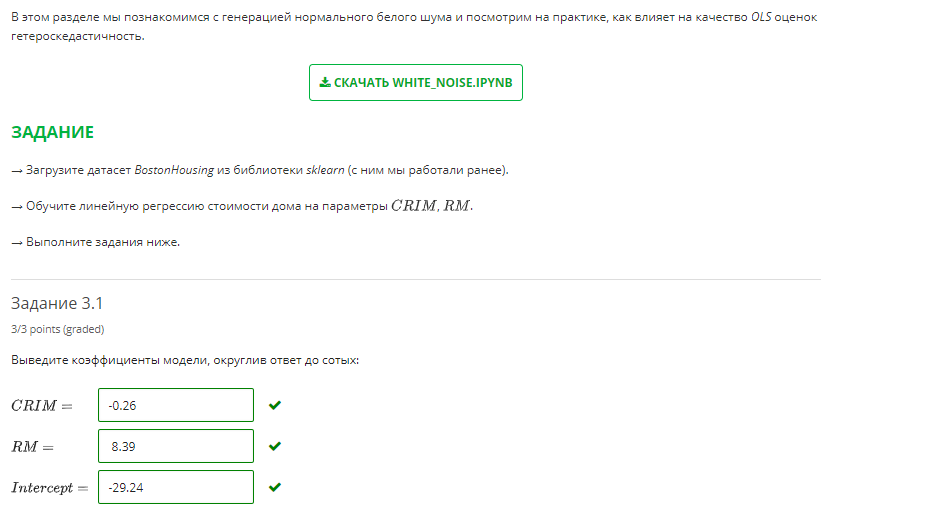

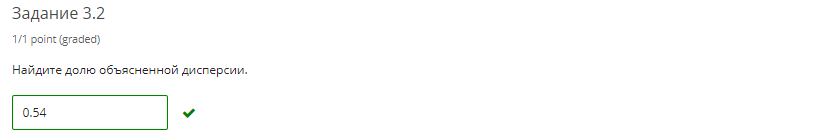

In [11]:
from sklearn.datasets import load_boston
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

boston = load_boston()
x = pd.DataFrame(boston.data)
x.columns = boston.feature_names
y=pd.DataFrame(boston.target)
y.columns=['TARGET']
print(x.shape)

x1 = x[['CRIM','RM']] 

def LR(x,y):
    linreg = linear_model.LinearRegression() 
    linreg.fit(x,y)
    # выведем коэффициенты
    print(linreg.intercept_,linreg.coef_)
    # найдем оценки y
    y_pred = linreg.predict(x)
    
    # выведем r2_score
    print(r2_score(y,y_pred))
    
LR(x1,y) 

(506, 13)
[-29.24471945] [[-0.26491325  8.39106825]]
0.5419591738494083


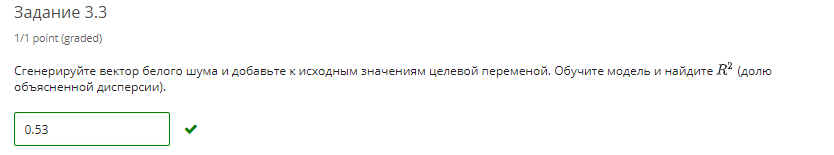

In [6]:
mu = 0
sigma = 1 

epss = np.random.normal(mu, sigma, size=y.shape[0])
y_eps = y+epss.reshape(-1,1)
    
LR(x1,y_eps)

[-29.79971352] [[-0.25832454  8.47083876]]
0.5364384000903223


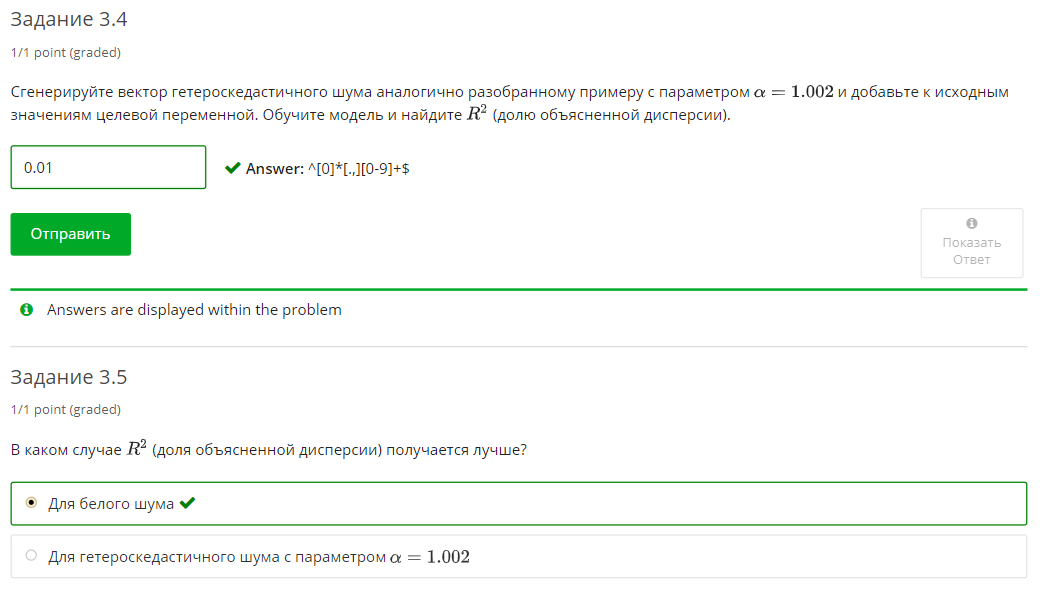

In [7]:
alpha = 1.002
def hetero_eps(alpha, eps):
    hetero_eps = np.zeros(len(eps))
    for i in range (0,len(eps)):
        hetero_eps[i] = (alpha**i) * eps[i]
    return hetero_eps


heteps = hetero_eps(alpha,epss)
y_eps = y+heteps.reshape(-1,1)

LR(x1,y_eps)



[-30.21370936] [[-0.25212038  8.52998259]]
0.5265192767504732


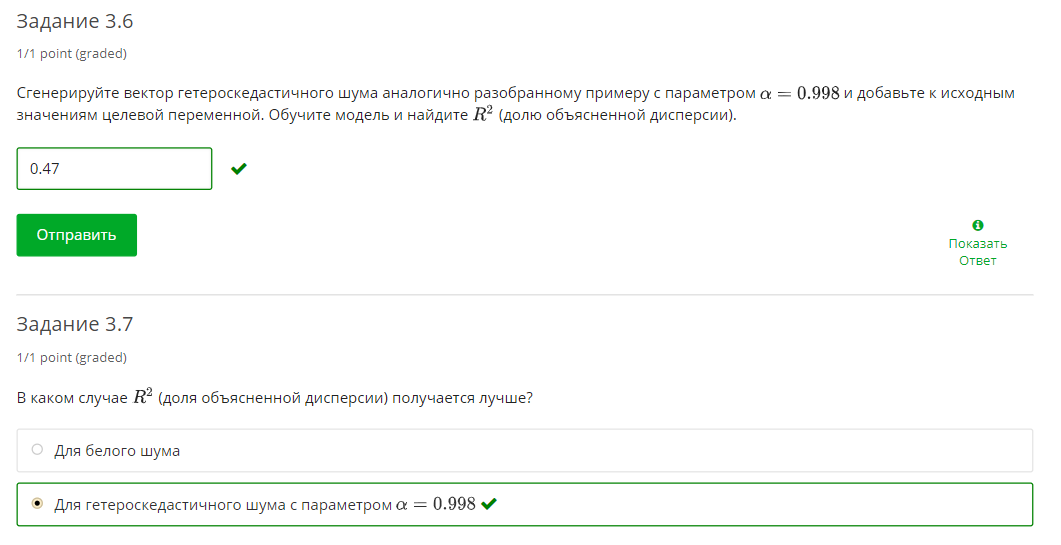

In [12]:
alpha = 0.998
def hetero_eps(alpha, eps):
    hetero_eps = np.zeros(len(eps))
    for i in range (0,len(eps)):
        hetero_eps[i] = (alpha**i) * eps[i]
    return hetero_eps


heteps = hetero_eps(alpha,epss)
y_eps = y+heteps.reshape(-1,1)

LR(x1,y_eps)

[-29.57994242] [[-0.26129071  8.43898601]]
0.5388200368673839


Для гетероскедастичного шума с параметром  alpha=0.998 доля объясненной дисперсии больше, тк стпеннная функция с основанием 0.998 - убывающая, а с основанием 1.002 возрастающая.для гетероскедастичного шума с alpha  < 1 шум медленно "исчезает" и R2 приближается к значению без шума

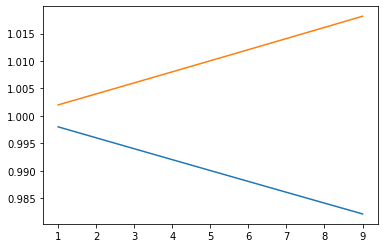

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = plt.axes()
ax.plot(np.arange(1,10),  [0.998**i for i in range(1,10)])
ax.plot(np.arange(1,10),  [1.002**i for i in range(1,10)])

# Предсказание и объяснение
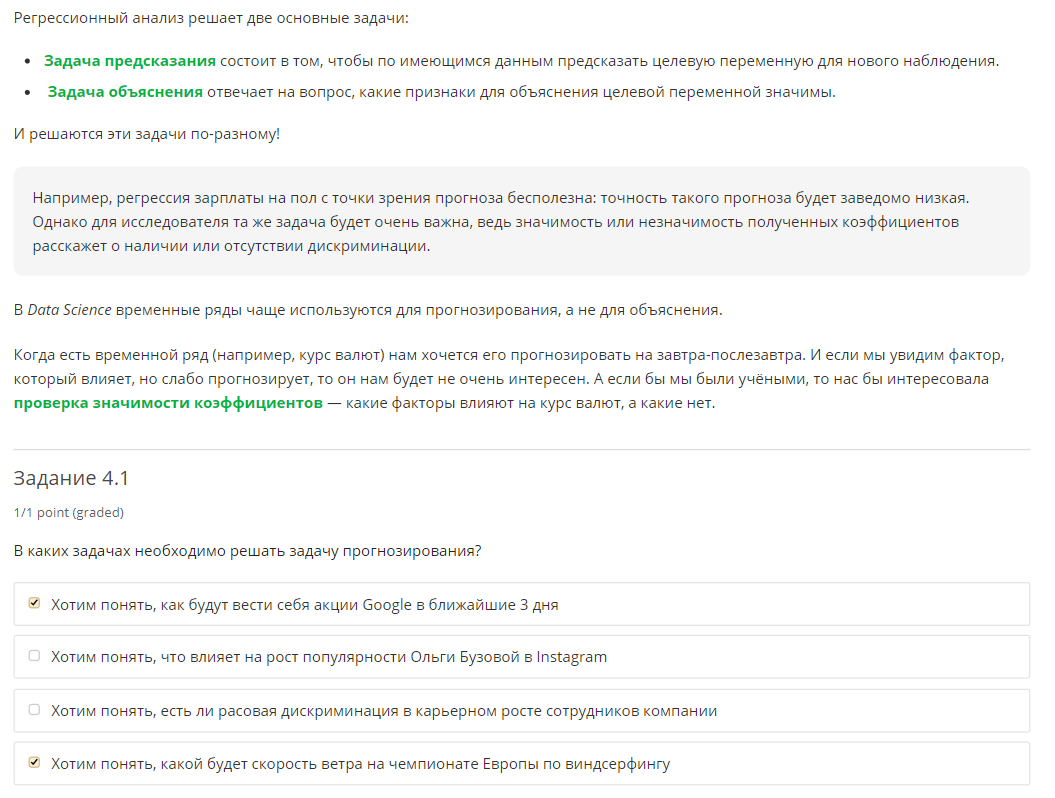

# Скользящее среднее
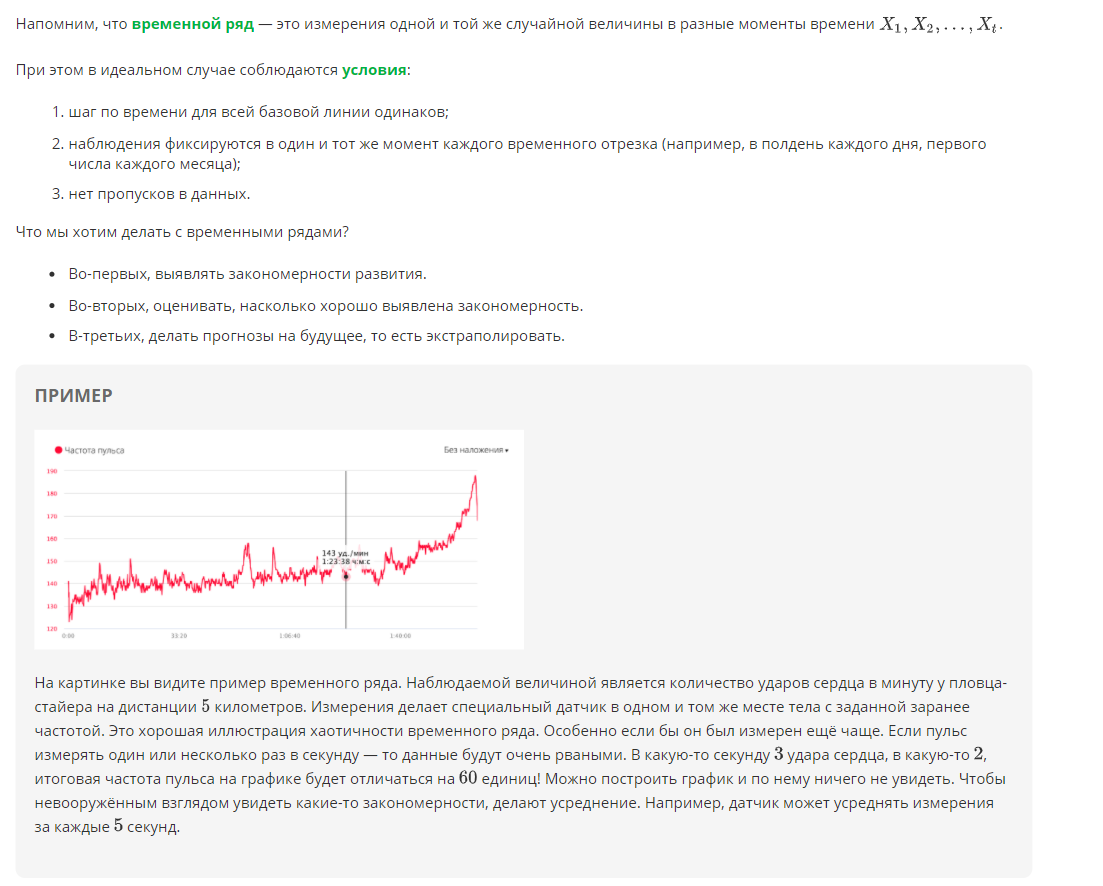

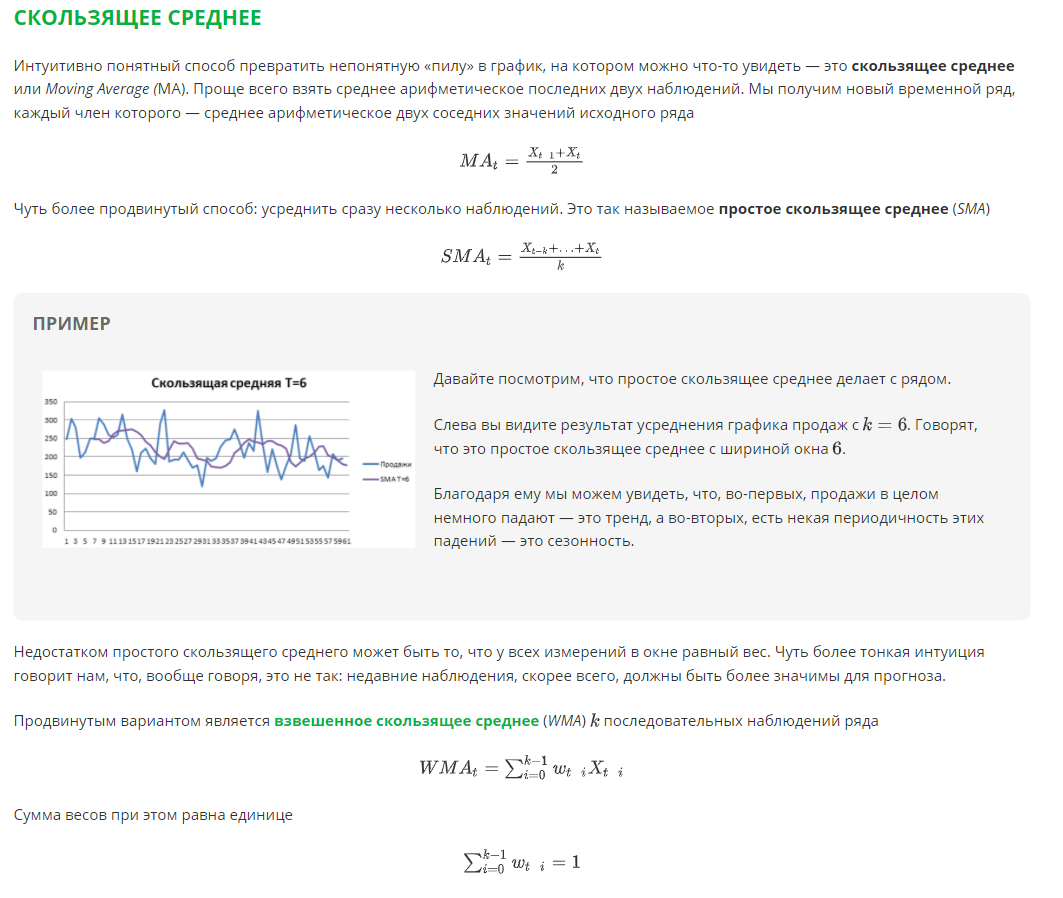

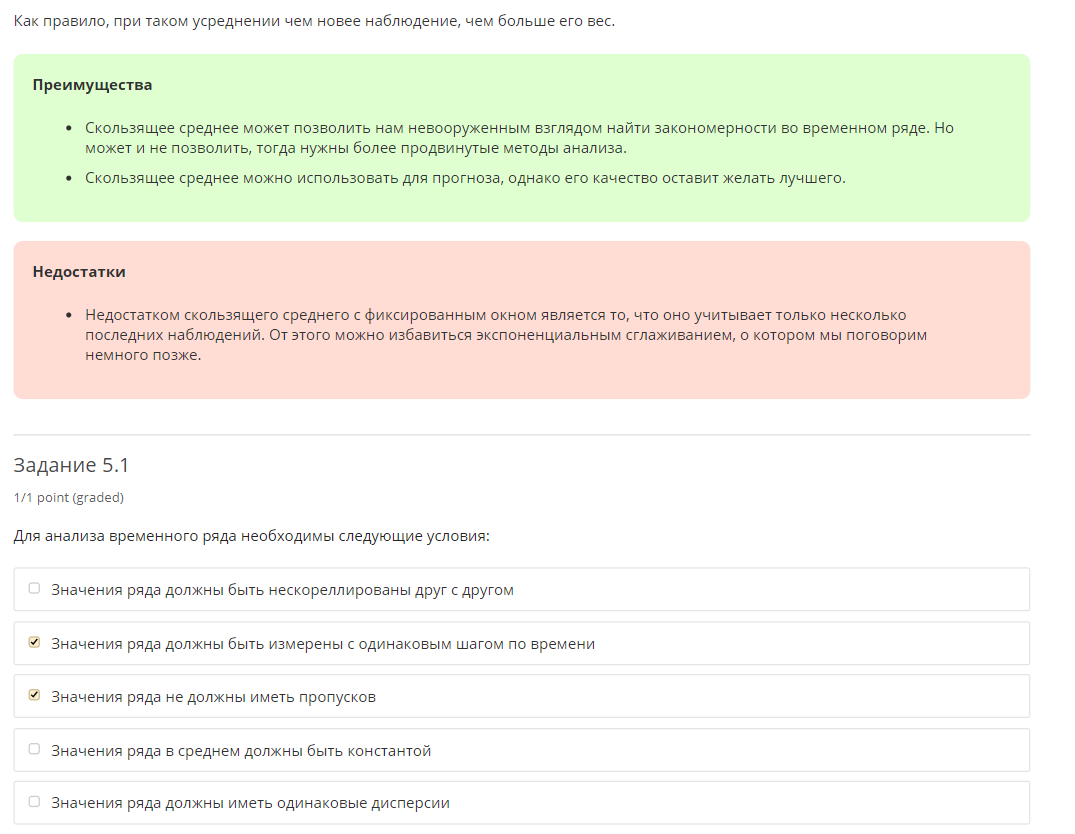

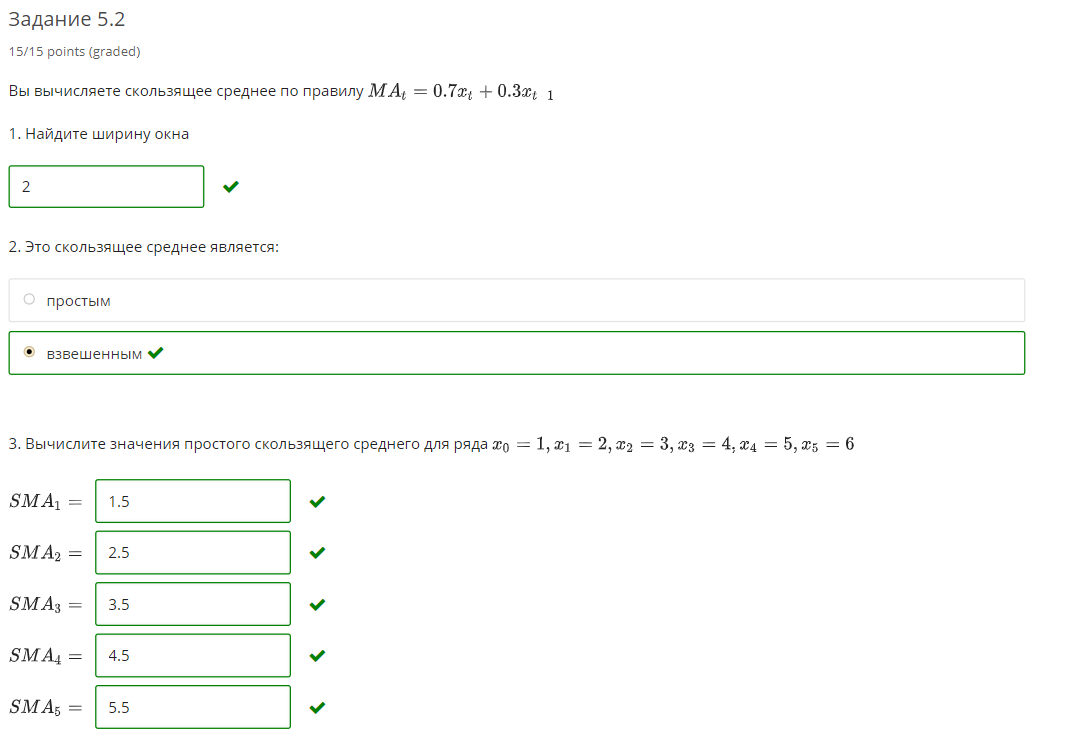

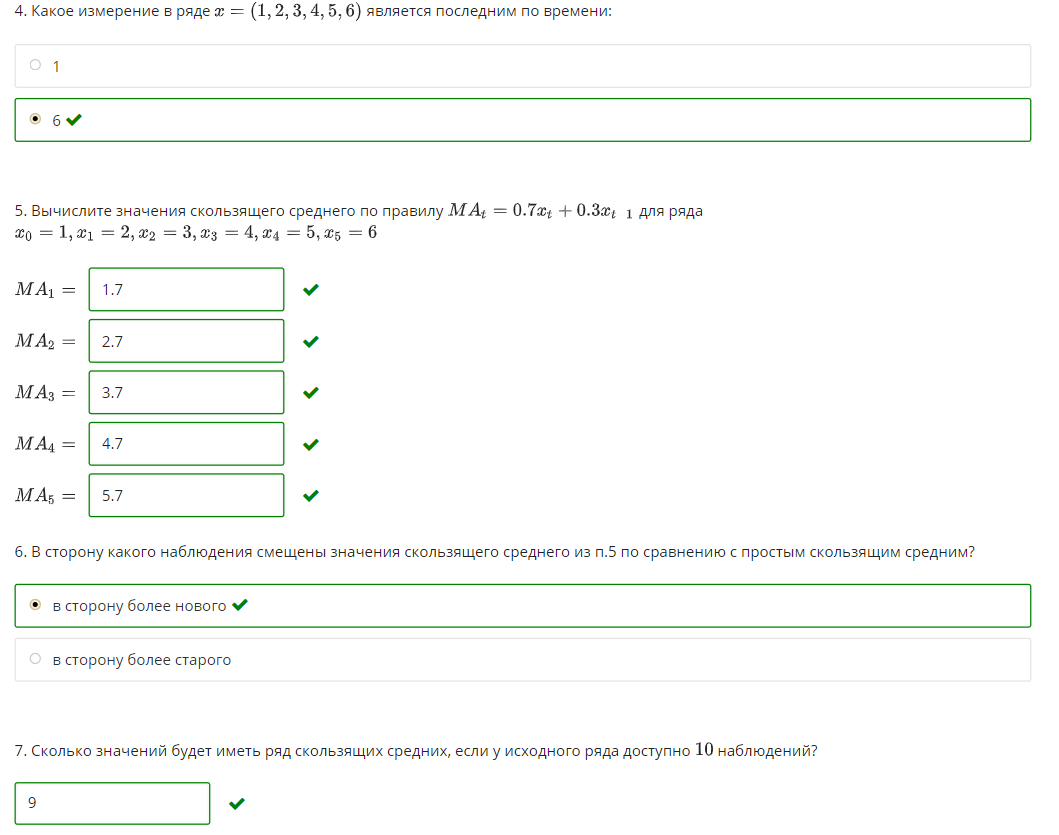

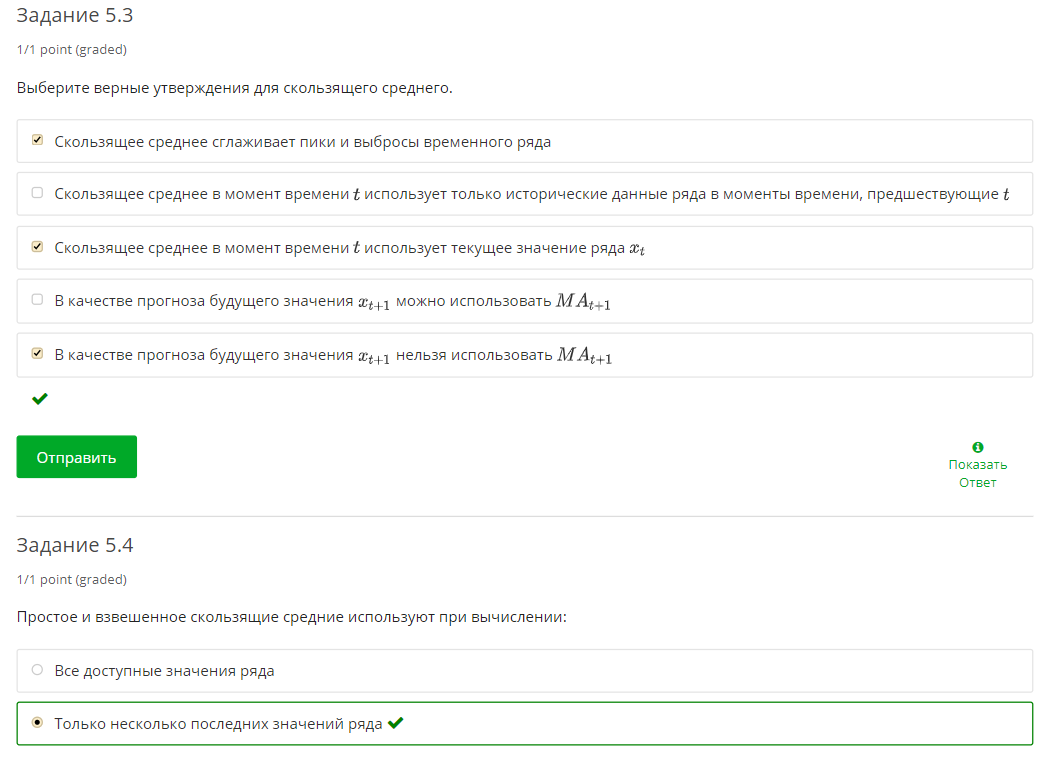

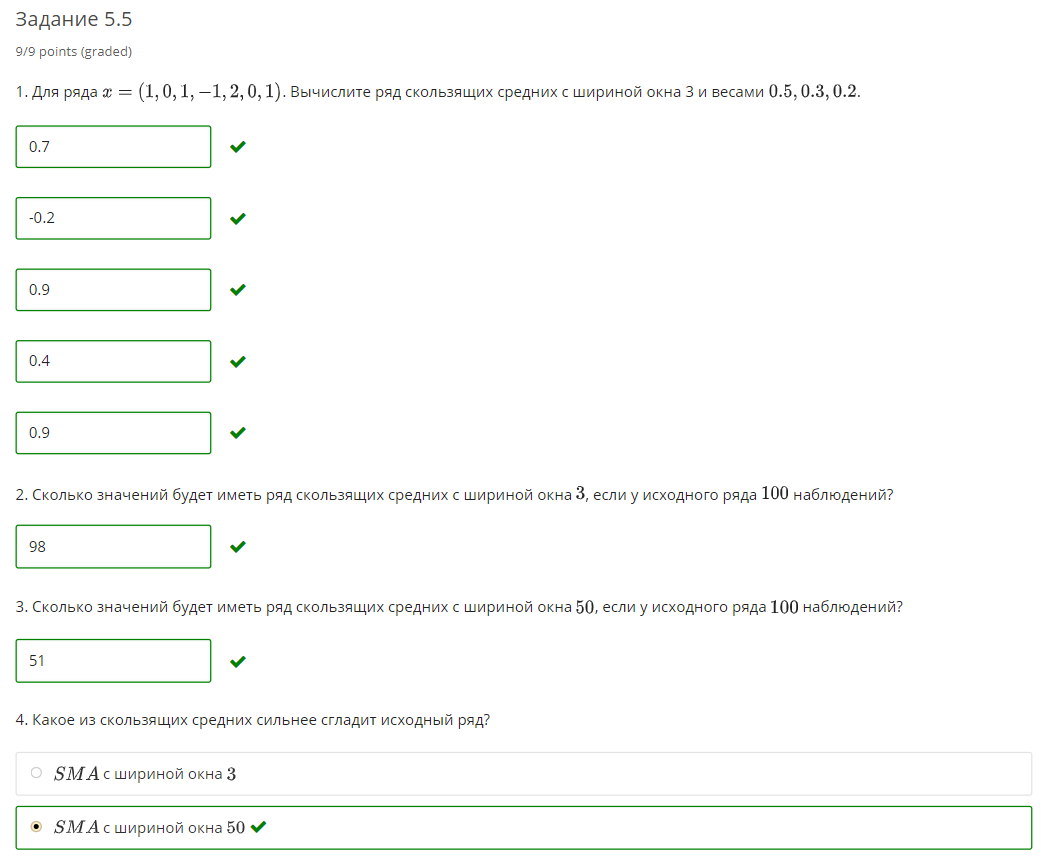

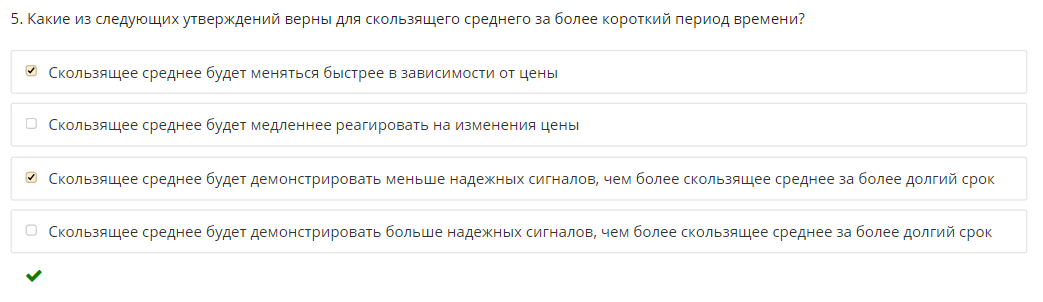

# Практика. Скользящее среднее
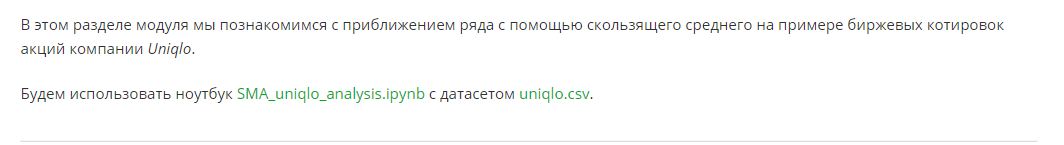

In [16]:
# импорт библиотек и датасета
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('uniqlo.csv')
# посмотрим глазами на начало датасета
# можно увидеть, что данные отсортированы в обратном порядке
# кроме того, данных за некоторые дни нет (например, 2016-12-18)
# приведем формата даты к стандарту datetime. 
# это стандартный тип данных, который позволит нам красиво отображать графики по временнЫм осям
# и делать разные операции, например заполнять недостающие данные по дням
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
# переименуем индексы строк в даты
df = df.set_index(pd.DatetimeIndex(df['Date']))
# столбец Date нам больше не нужен, удалим его
df.drop(['Date'], axis =1, inplace = True)
# заполним данные по пропущенным дням
# метод resample('d') выполняет группировку данных по дням,
# а ffill заполнит получившиеся пропуски, взяв предыдущее значение вместо пропущенного
df = df.resample('d').ffill()
print(df.isnull().sum()) # проверим, что пропущенных дней больше нет
# создадим отдельный Series для цен открытия биржи
OpenPrice = df.Open
OpenPrice.head()

df.head(15)

Open             0
High             0
Low              0
Close            0
Volume           0
Stock Trading    0
dtype: int64


Open   High    Low  Close   Volume  Stock Trading
Date                                                          
2012-01-04  14050  14050  13700  13720   559100     7719804000
2012-01-05  13720  13840  13600  13800   511500     7030811000
2012-01-06  13990  14030  13790  13850   765500    10635609000
2012-01-07  13990  14030  13790  13850   765500    10635609000
2012-01-08  13990  14030  13790  13850   765500    10635609000
2012-01-09  13990  14030  13790  13850   765500    10635609000
2012-01-10  13890  14390  13860  14390   952300    13533413000
2012-01-11  14360  14750  14280  14590  1043400    15191988000
2012-01-12  14520  14600  14330  14520   540500     7814121000
2012-01-13  14740  14780  14450  14770  1543700    22669096000
2012-01-14  14740  14780  14450  14770  1543700    22669096000
2012-01-15  14740  14780  14450  14770  1543700    22669096000
2012-01-16  14610  14670  14530  14610   360100     5255652000
2012-01-17  14640  14820  14630  14750   442100     6511265000
2012-01-18  14780  15000  14740  14980   650300     9677803000

Нарисуем приближение простым скользящим средним с шириной окна 2

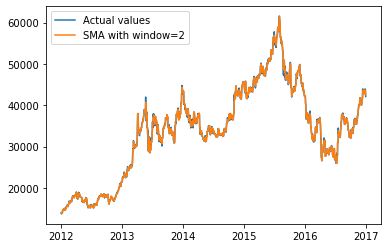

In [17]:
# метод rolling умеет делать скользящие преобразования. 
# Параметр window задает ширину окна, а mean() говорит, что в окне нужно взять среднее арифметическое
result1 = OpenPrice.rolling(window = 2).mean()
# Нарисуем красивый график
plt.plot(OpenPrice,label="Actual values")
plt.plot(result1,label="SMA with window=2")
plt.legend(loc="upper left")
plt.show()

Нарисуем приближение простым скользящим средним с шириной окна 10

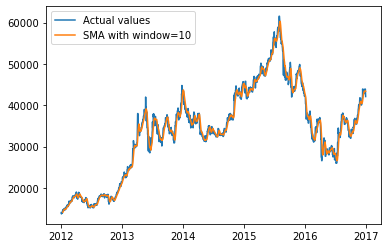

In [18]:
result2 = OpenPrice.rolling(window = 10).mean()
plt.plot(OpenPrice,label="Actual values")
plt.plot(result2,label="SMA with window=10")
plt.legend(loc="upper left")
plt.show()

Нарисуем приближение простым скользящим средним с шириной окна 50.

Можно заметить, что оранжевый график приближения начинается позже графика истинных значений.

Подумайте, почему так получается?

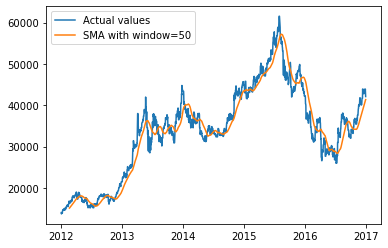

In [19]:
result3 = OpenPrice.rolling(window = 50).mean()
plt.plot(OpenPrice,label="Actual values")
plt.plot(result3,label="SMA with window=50")
plt.legend(loc="upper left")
plt.show()

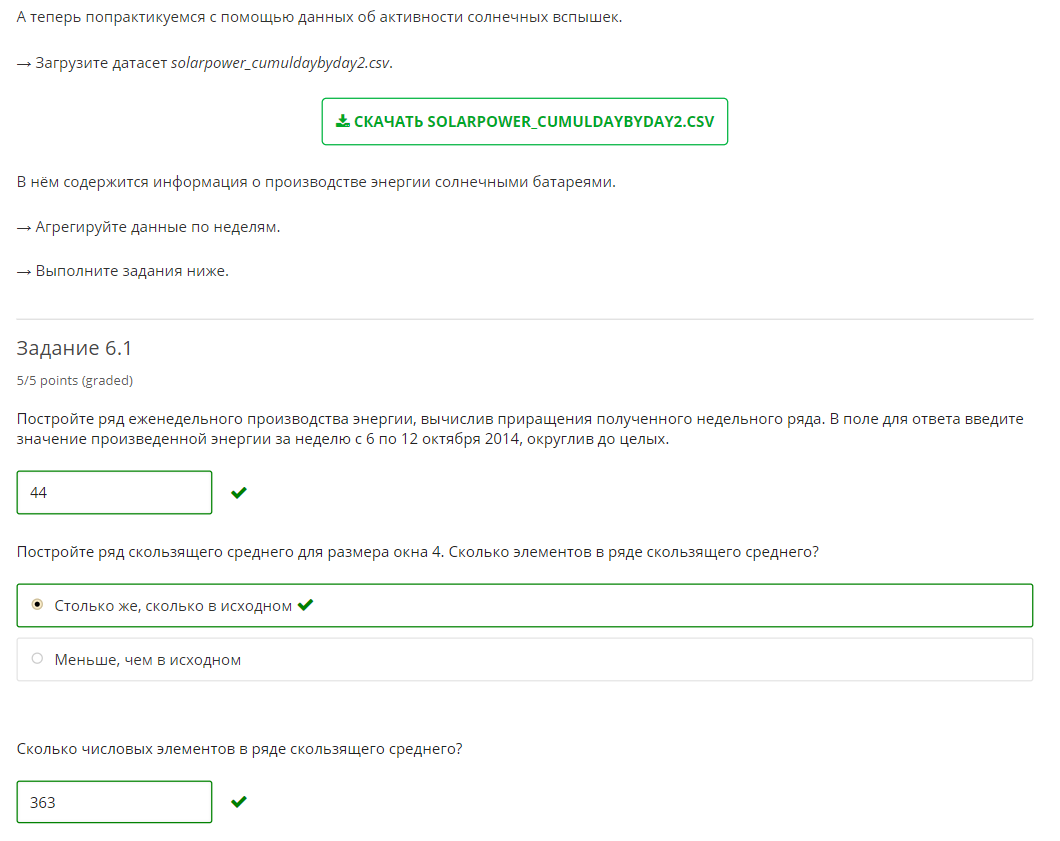

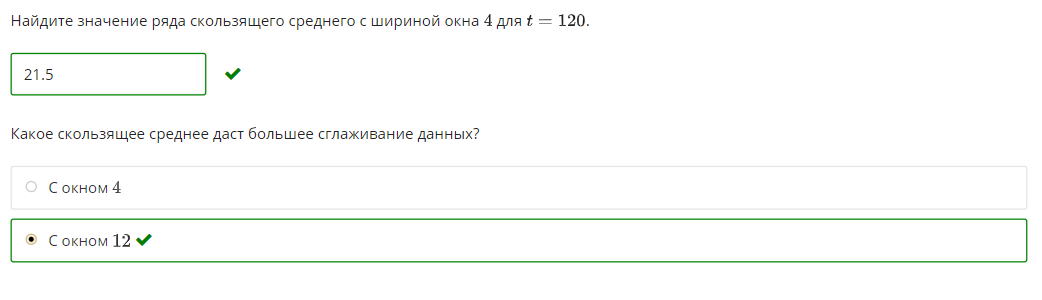

In [23]:
df_2 = pd.read_csv('solarpower_cumuldaybyday2.csv')
df_2.drop('Unnamed: 2',axis=1,inplace=True)
df_2['date'] = pd.to_datetime(df_2['date'], format = '%d/%m/%Y')
# переименуем индексы строк в даты
df_2 = df_2.set_index(pd.DatetimeIndex(df_2['date']))
# столбец Date нам больше не нужен, удалим его
df_2.drop(['date'], axis =1, inplace = True)
df_2['power_diff_previous_day'] = df_2.diff()
df_2['power_diff_previous_day'] = df_2['power_diff_previous_day'].fillna(0)
# Постройте ряд еженедельного производства энергии, вычислив приращения полученного недельного ряда.
# Найти значение произведенной энергии за неделю с 6 по 12 октября 2014, округлив до целых.
weekly_diff_set = pd.DataFrame(df_2['power_diff_previous_day'].resample('W').sum())
print(weekly_diff_set[weekly_diff_set.index =='2014-10-12'])
weekly_diff_set['rollig_window_4_day'] = weekly_diff_set.rolling(window = 4).mean()
# Найдите значение ряда скользящего среднего с шириной окна 4  для t=120 .
print(weekly_diff_set.iloc[119])


            power_diff_previous_day
date                               
2014-10-12                     44.0
power_diff_previous_day    28.0
rollig_window_4_day        21.5
Name: 2014-02-09 00:00:00, dtype: float64


# Тренд и сезонность
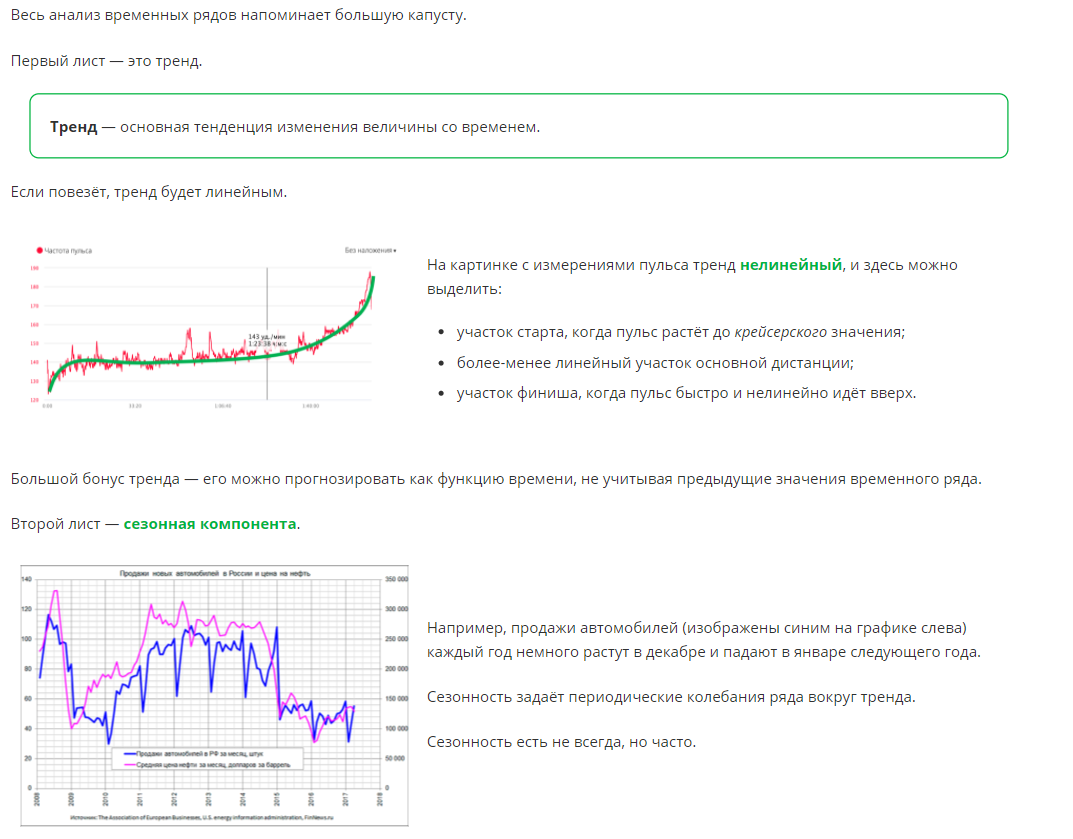

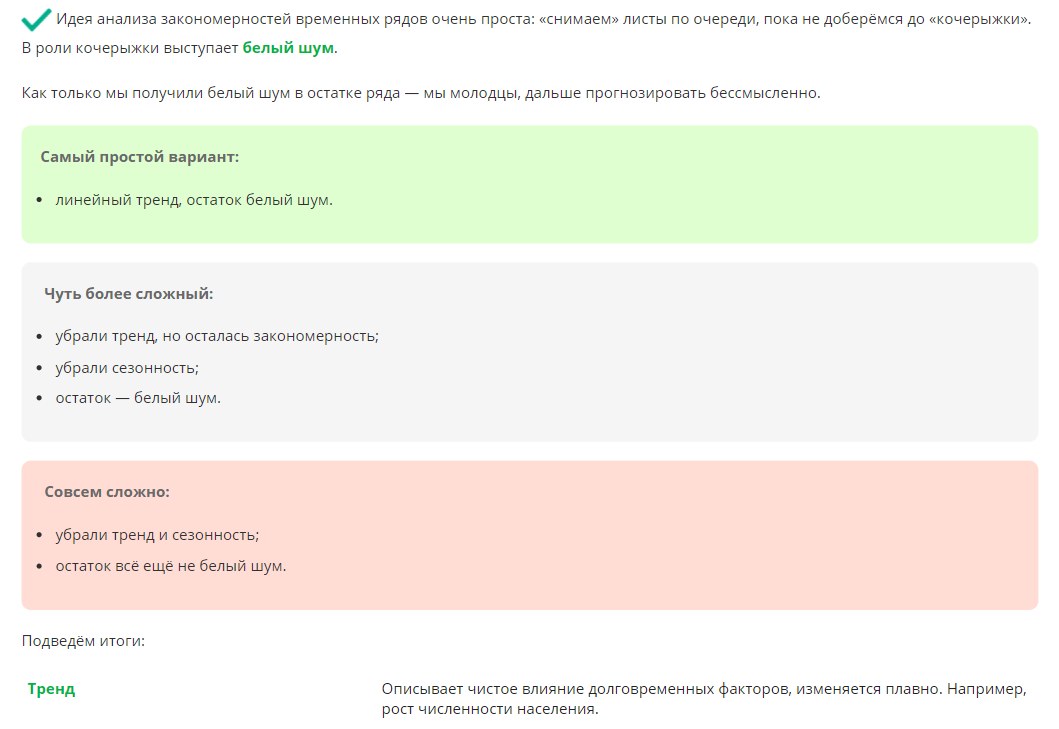

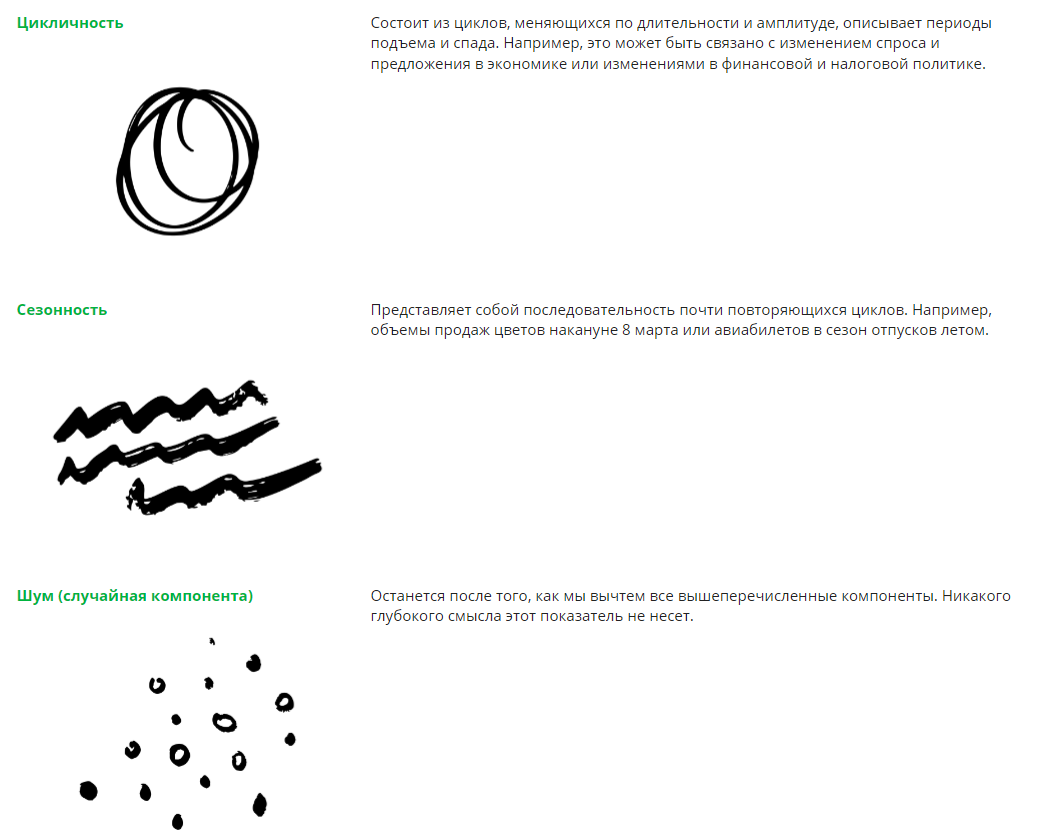

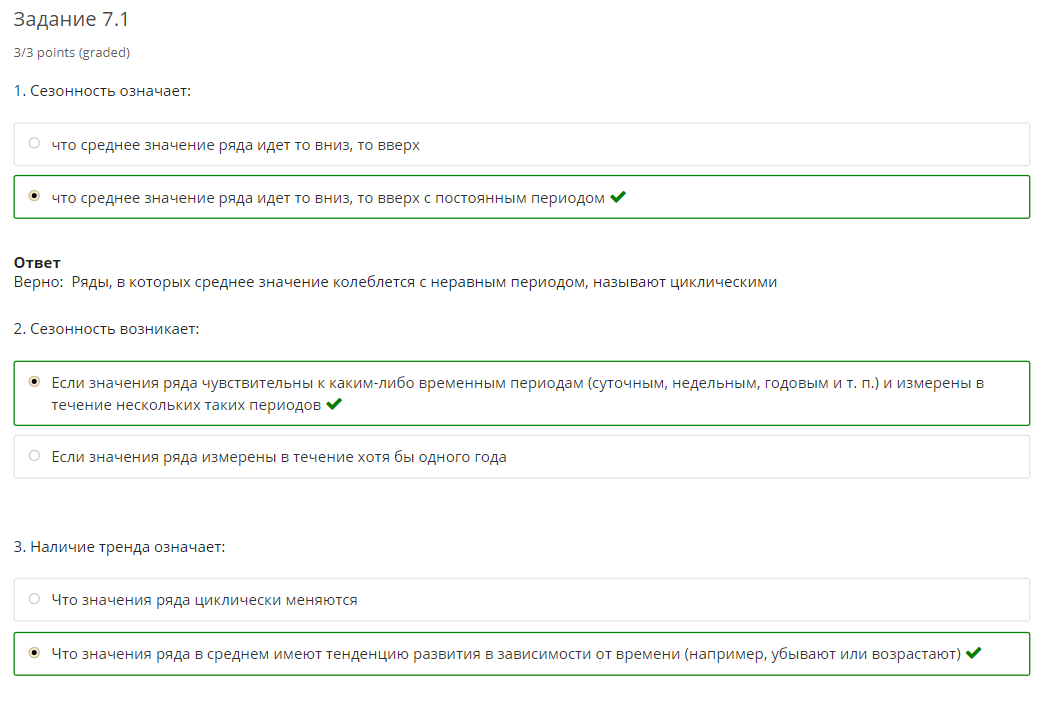

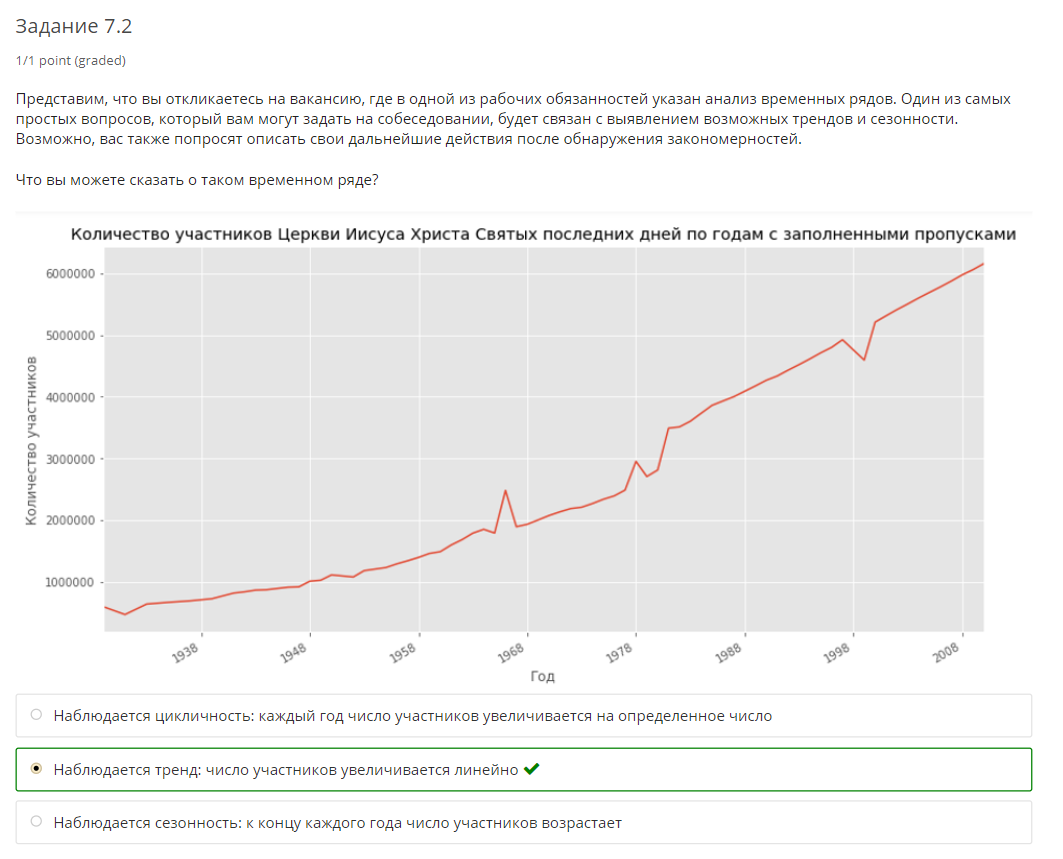

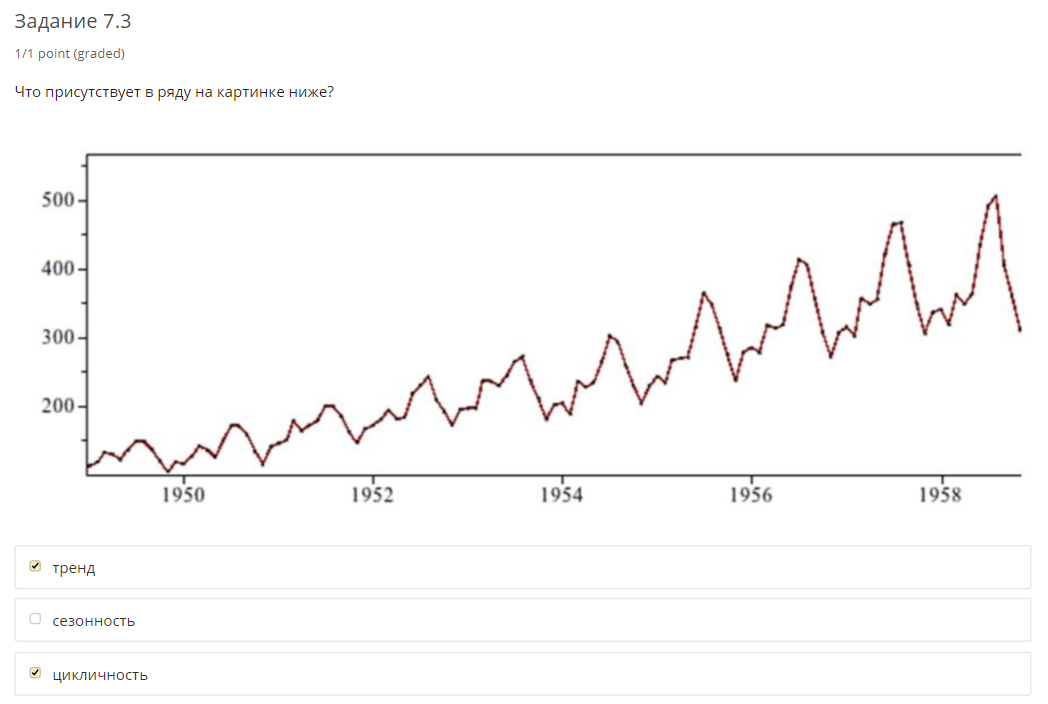

# Нестационарные временные ряды
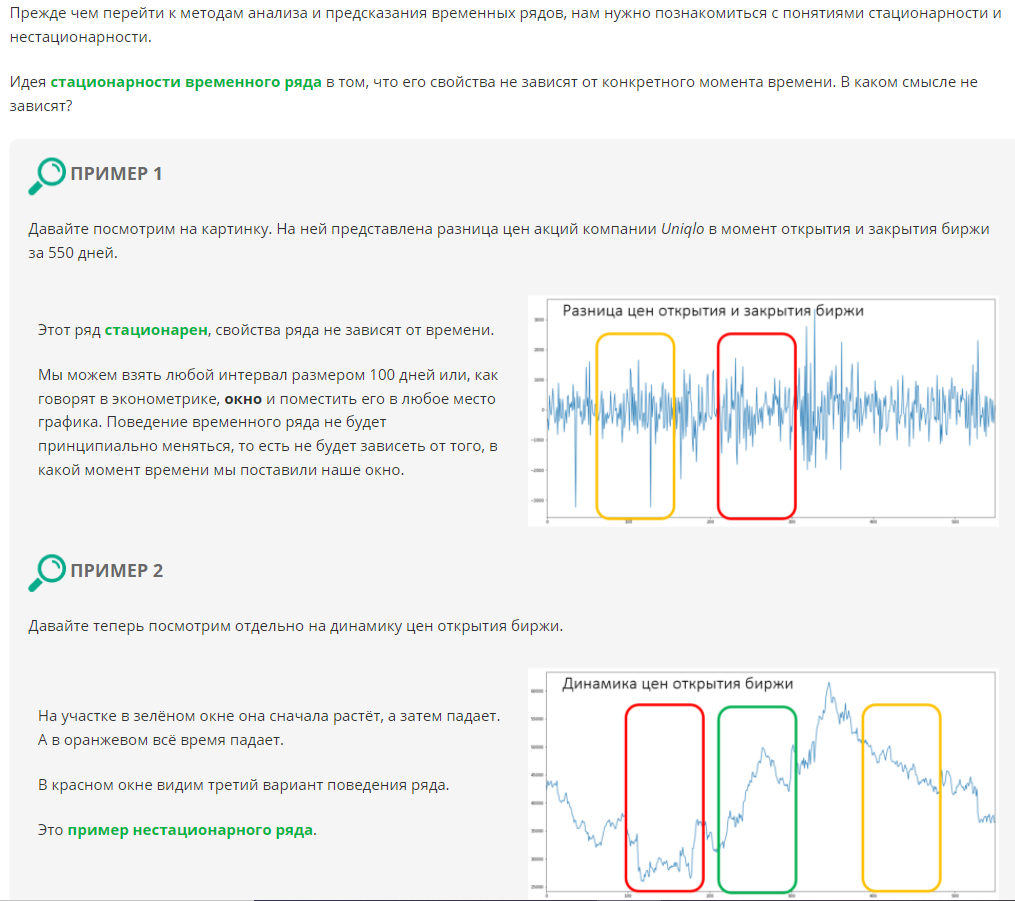

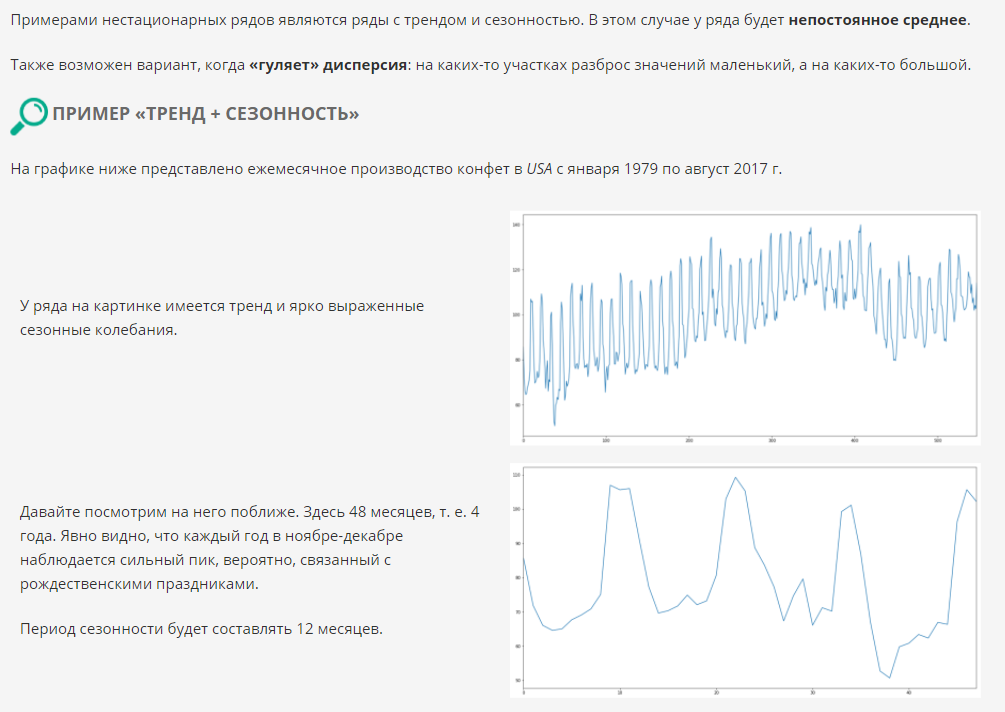

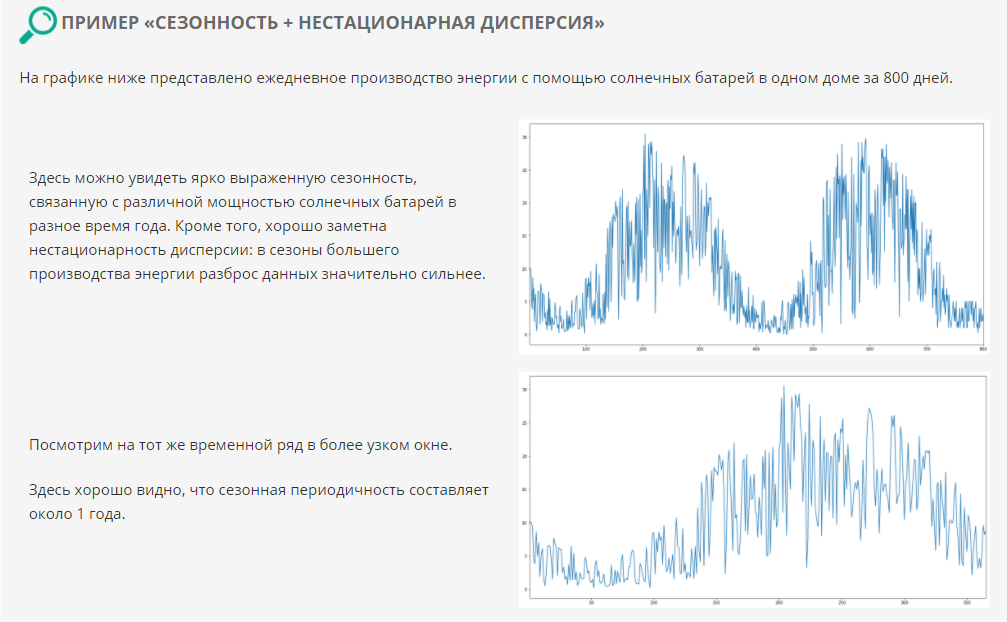

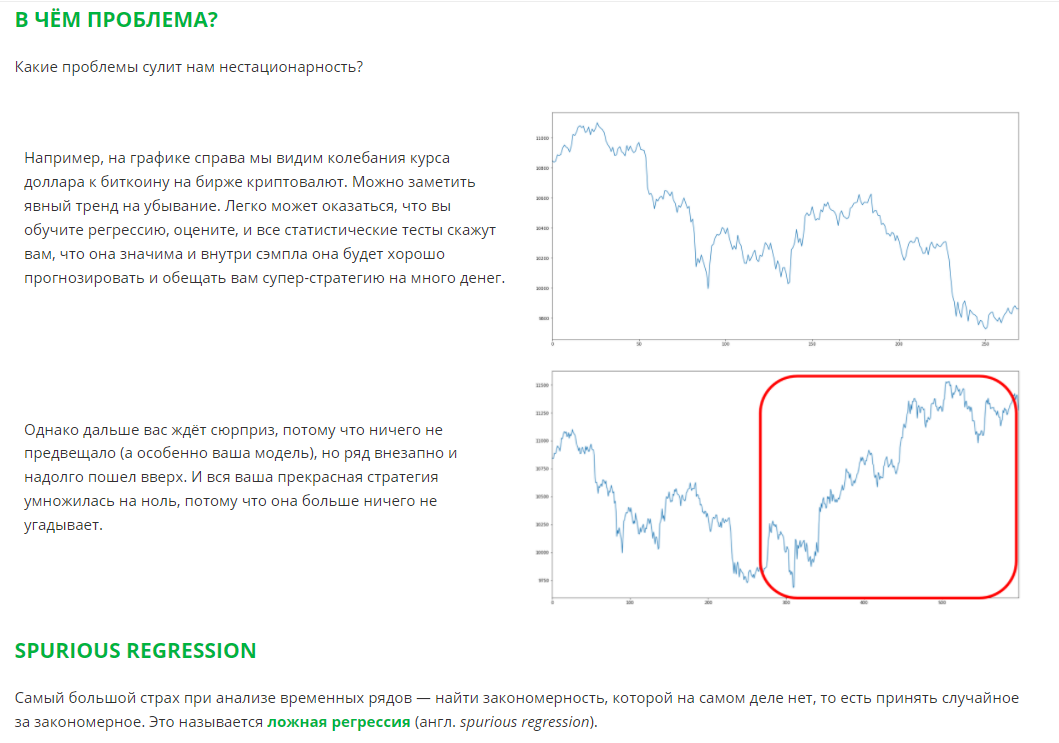

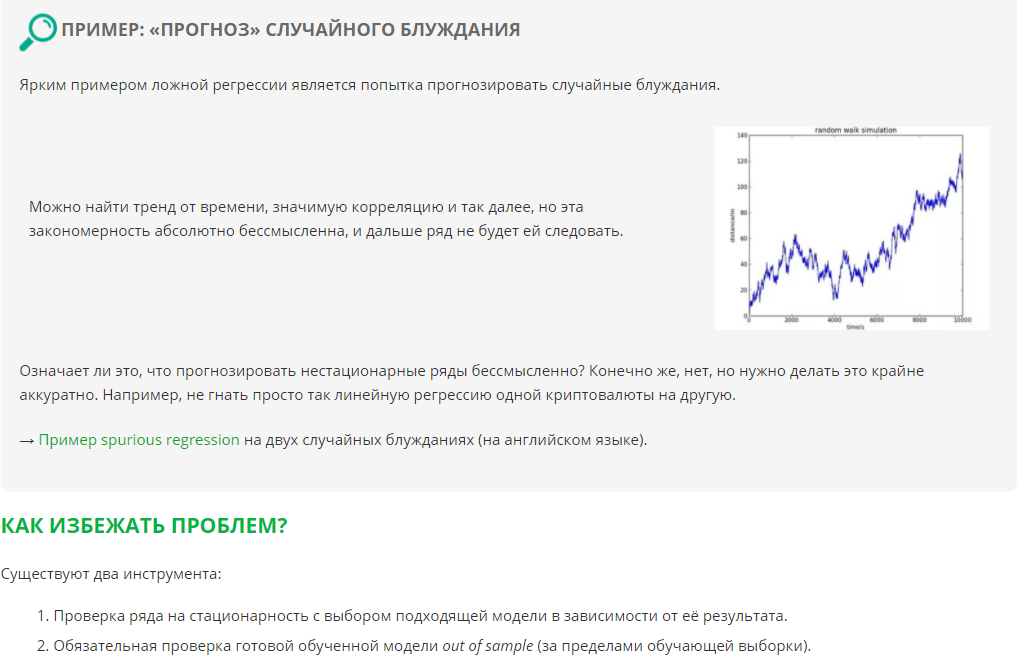

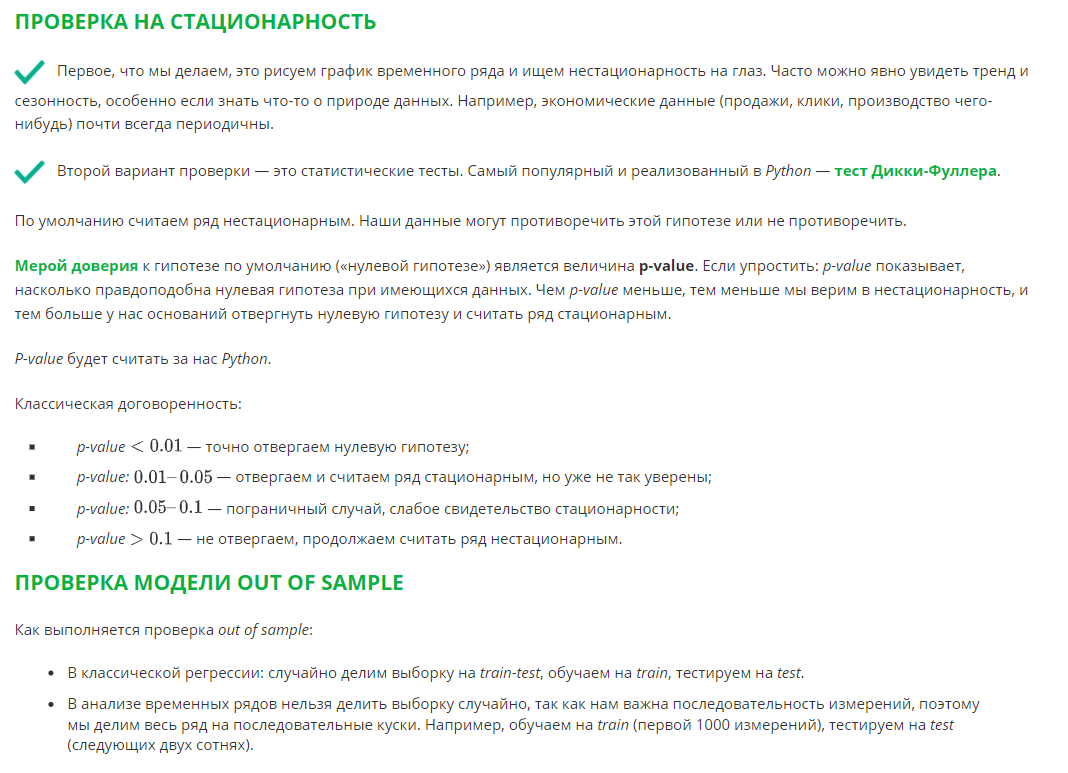

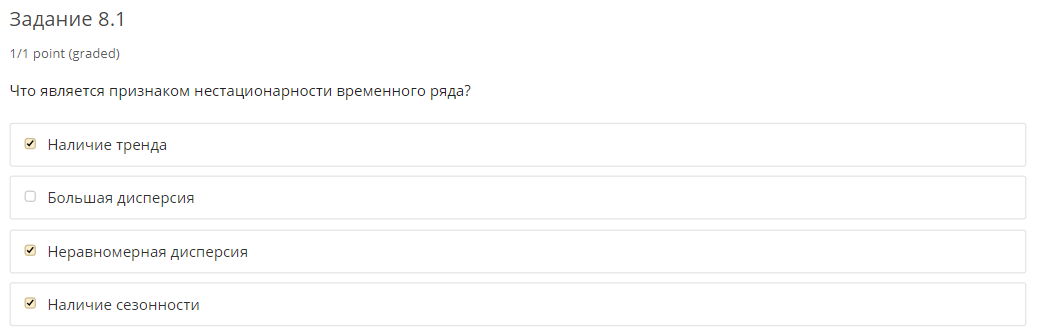

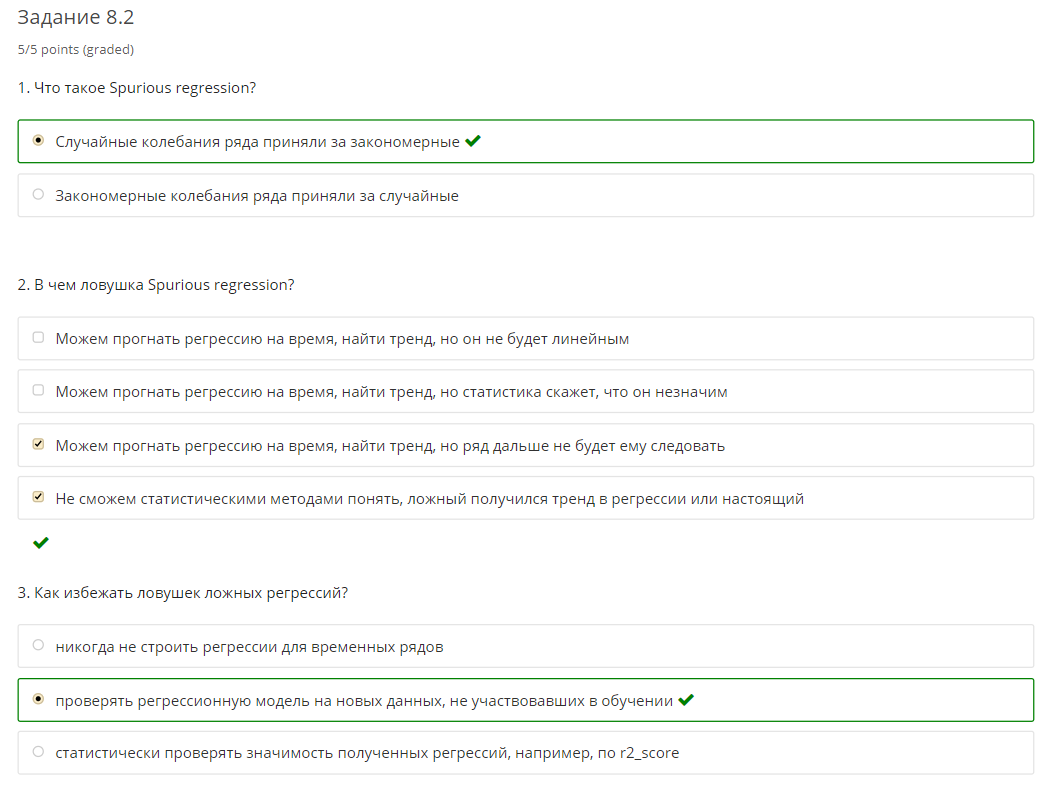

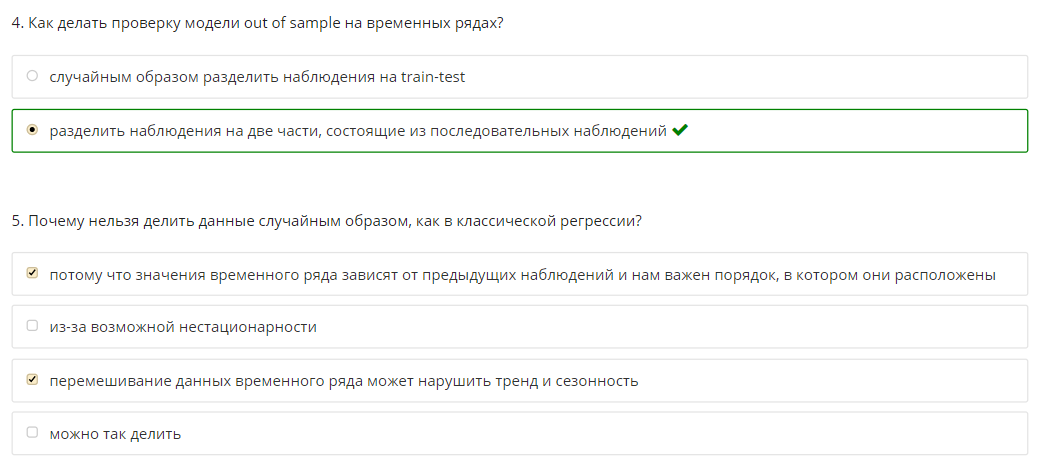

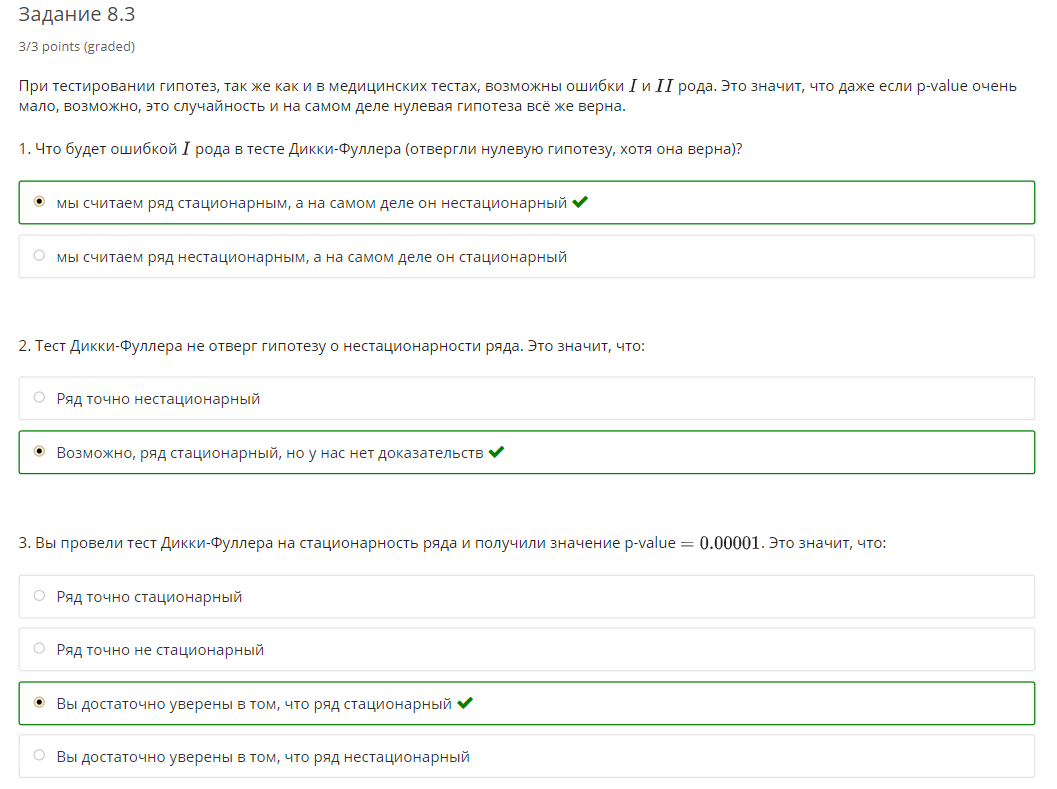

# Практика. Нестационарность
В этом блоке мы познакомимся со случайными блужданиями.

Узнаем, что это такое, как их можно построить и в каких случаях они стационарны

рассмотрим такую задачу: Очень нерешительный таракан Афанасий путешествует по числовой прямой. В каждый момент времени он подбрасывает монетку: если выпал орел, идет на один сантиметр вперед, а если решка, то назад.

Такие последовательности называются случайными блужданиями. В них каждое следующее положение получается из предыдущего добавлением какого-нибудь белого шума. В нашем случае - равномерного со значениями -1 и 1. Другими словами, приращения случайных блужданий - белый шум, то есть абсолютно случайны. Создадим функцию, которая будет генерировать последовательность координат Афанасия на прямой

Uni означает, что в качестве случайности берется равновероятная (Uniform) модель

rwalk - random walk.

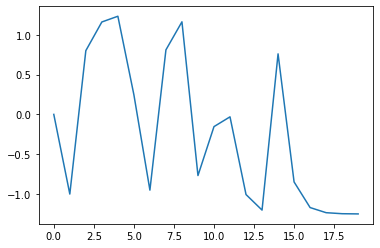

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

def unirwalk(num):
    uwalk = np.zeros(num)
    for i in range (1,num):
        # random.randint(-1,1) имитирует подброс монетки. Афанасий сдвигается на один см влево (-1) или вправо (1)
        # относительно прыдыдущего положения uwalk[i-1]
        uwalk[i] = 0.2*uwalk[i-1] + random.randint(-1,1) 
    return uwalk

# посмотрим, как будет выглядеть блуждание на 20 шагах
walk = unirwalk(20)
plt.plot(walk)

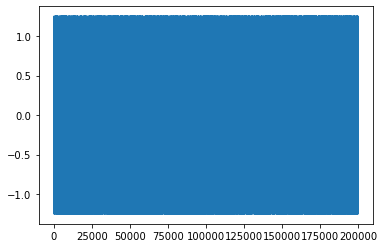

In [39]:
# посмотрим, как будет выглядеть блуждание на 2000 шагах
walk2 = unirwalk(200000)
plt.plot(walk2)

Чем больше временной интервал, тем дальше будет удалаяться Афанасий от точки старта

In [40]:
# среднее значение и стандартное отклонение случайного блуждания:
print('mean и std для num=20:',np.mean(walk), np.std(walk))
print('mean и std для num=2000:',np.mean(walk2), np.std(walk2))

mean и std для num=20: -0.2343830390174646 0.9150592394223749
mean и std для num=2000: 0.0016300399237378065 0.8339038965298264


создадим нормальное случайное блуждание

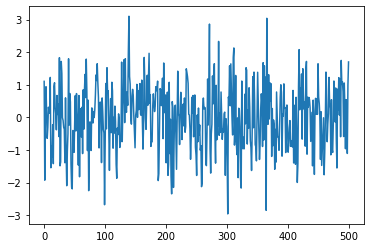

In [41]:
# num - число шагов
# a - множитель. В каждый момент времени следующее значение равно a*текущее + белый шум
# mu, sigma - параметры шума
def normrwalk(num,a, mu, sigma):
    eps = np.random.normal(mu, sigma, size=num)
    walk = np.zeros(num)
    walk[0] = eps[0]
    for i in range (1,num):
        walk[i] = a*walk[i-1] + eps[i]
    return walk
    
    
# Давайте посмотрим, как ведет себя нормальное случайное блуждание для значения a=0.1, 0.5, 0.9, и 1    
a = 0.1
n_walk_01 = normrwalk(500, a, 0, 1)
plt.plot(n_walk_01)

In [42]:
# Протестируем стационарность ряда при помощи теста Дикки-Фуллера

test = sm.tsa.adfuller(n_walk_01)
print ('p-value: ', test[1])
if test[1]< 0.05: 
    print (' ряд стационарен')
else:
    print ('ряд не стационарен')

p-value:  2.023451213940631e-30
 ряд стационарен


p-value:  1.0314115796386089e-22
 ряд стационарен


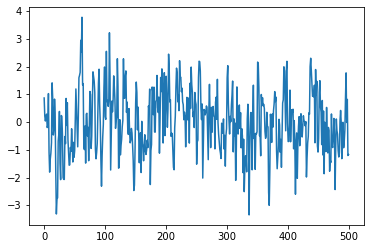

In [43]:
a = 0.5
n_walk_05 = normrwalk(500, a, 0, 1)
plt.plot(n_walk_05)

# Протестируем стационарность ряда при помощи теста Дикки-Фуллера
test = sm.tsa.adfuller(n_walk_05)
print ('p-value: ', test[1])
if test[1]< 0.05: 
    print (' ряд стационарен')
else:
    print ('ряд не стационарен')

p-value:  5.980089218153508e-05
 ряд стационарен


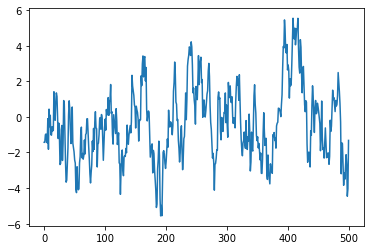

In [44]:
a = 0.9
n_walk_09 = normrwalk(500, a, 0, 1)
plt.plot(n_walk_09)

# Протестируем стационарность ряда при помощи теста Дикки-Фуллера
test = sm.tsa.adfuller(n_walk_09)
print ('p-value: ', test[1])
if test[1]< 0.05: 
    print (' ряд стационарен')
else:
    print ('ряд не стационарен')

При а=1 ряд резко меняет поведение и перестает быть стационарным! Это так называемый случай единичного корня, на идее которого и работает тест Дикки-Фуллера

p-value:  0.38256390570215093
ряд не стационарен


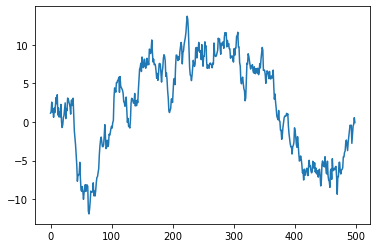

In [45]:
a = 1
n_walk_1 = normrwalk(500, a, 0, 1)
plt.plot(n_walk_1)

# Протестируем стационарность ряда при помощи теста Дикки-Фуллера
test = sm.tsa.adfuller(n_walk_1)
print ('p-value: ', test[1])
if test[1]< 0.05: 
    print (' ряд стационарен')
else:
    print ('ряд не стационарен')

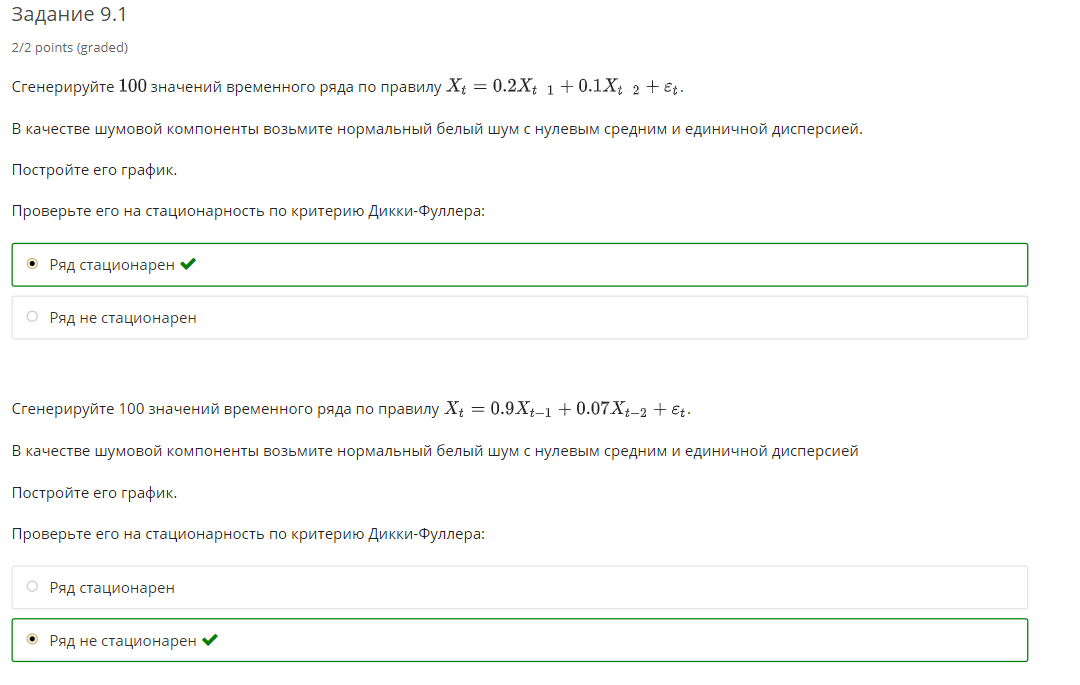

In [46]:
def normrwalk2(num,a,b, mu, sigma):
    eps = np.random.normal(mu, sigma, size=num)
    walk = np.zeros(num)
    walk[0] = eps[0]
    walk[1] = eps[1]
    for i in range (2,num):
        walk[i] = a*walk[i-1]+b*walk[i-2] + eps[i]
    return walk

p-value:  2.3834635264851692e-08
 ряд стационарен


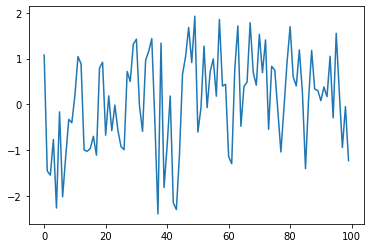

In [48]:
plt.plot(normrwalk2(100,0.2,0.1, 0,1))
# Протестируем стационарность ряда при помощи теста Дикки-Фуллера
test = sm.tsa.adfuller(normrwalk2(100,0.2,0.1, 0,1))
print ('p-value: ', test[1])
if test[1]< 0.05: 
    print (' ряд стационарен')
else:
    print ('ряд не стационарен')

p-value:  0.23998507365174804
ряд не стационарен


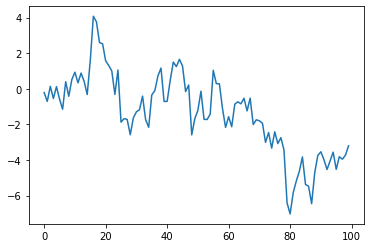

In [47]:
plt.plot(normrwalk2(100,0.9,0.07, 0,1))
# Протестируем стационарность ряда при помощи теста Дикки-Фуллера
test = sm.tsa.adfuller(normrwalk2(100,0.9,0.07, 0,1))
print ('p-value: ', test[1])
if test[1]< 0.05: 
    print (' ряд стационарен')
else:
    print ('ряд не стационарен')

# Модель прогнозирования ARMA

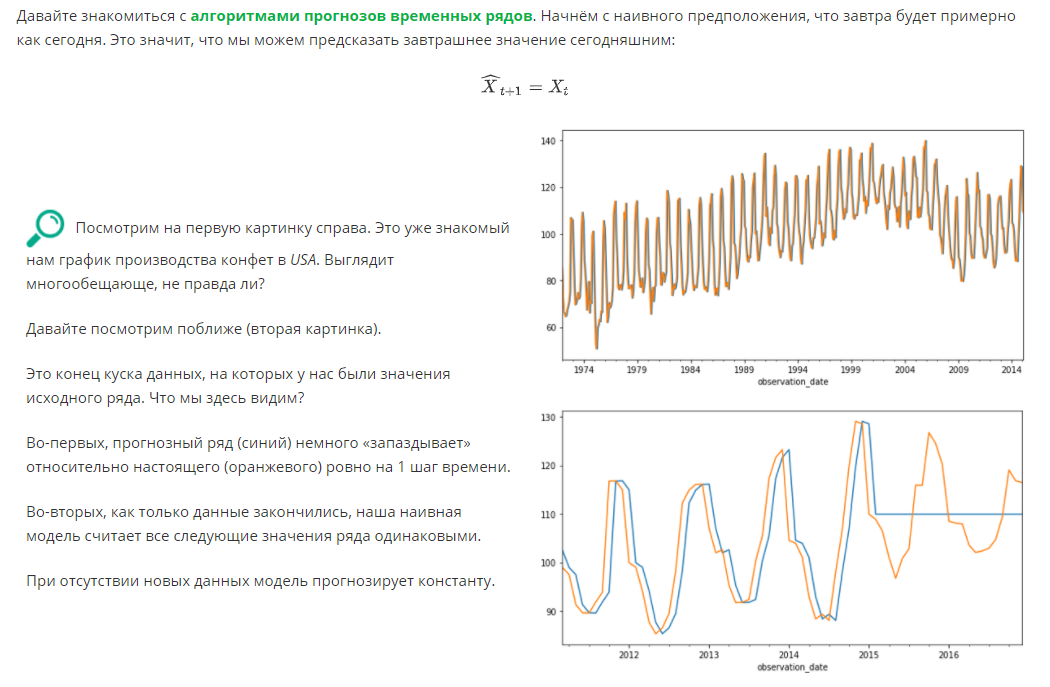

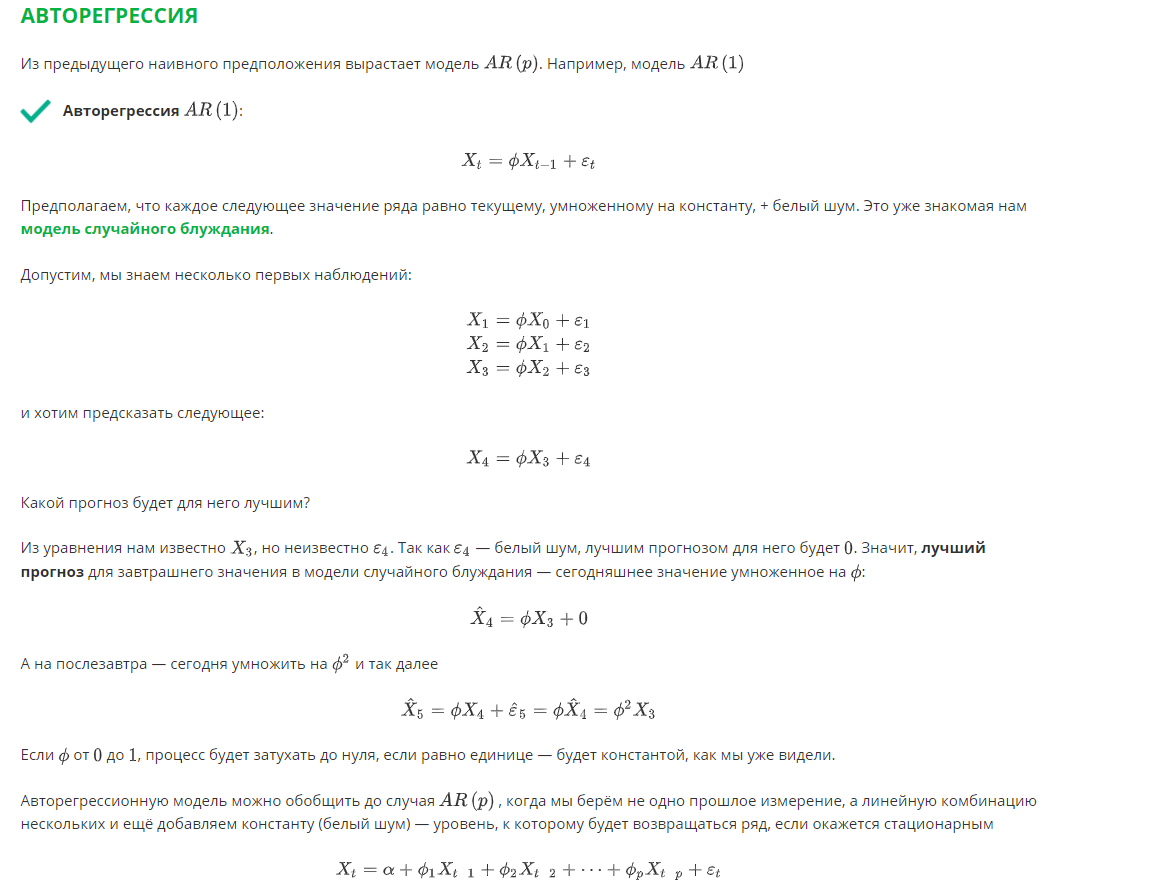

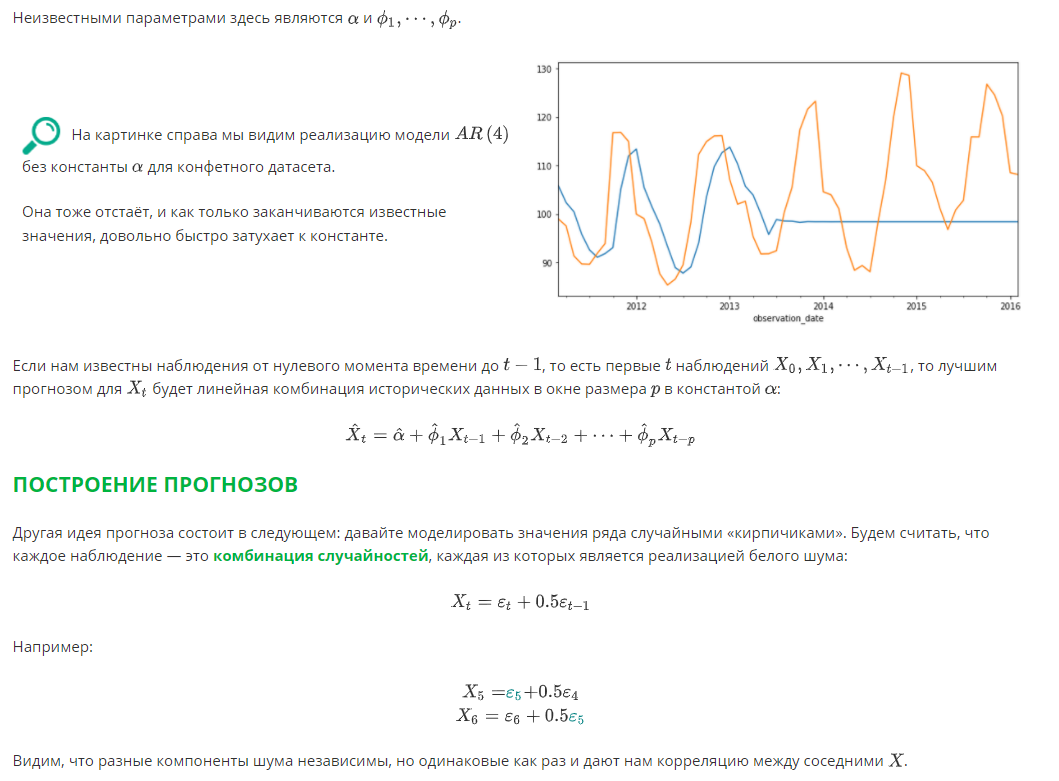

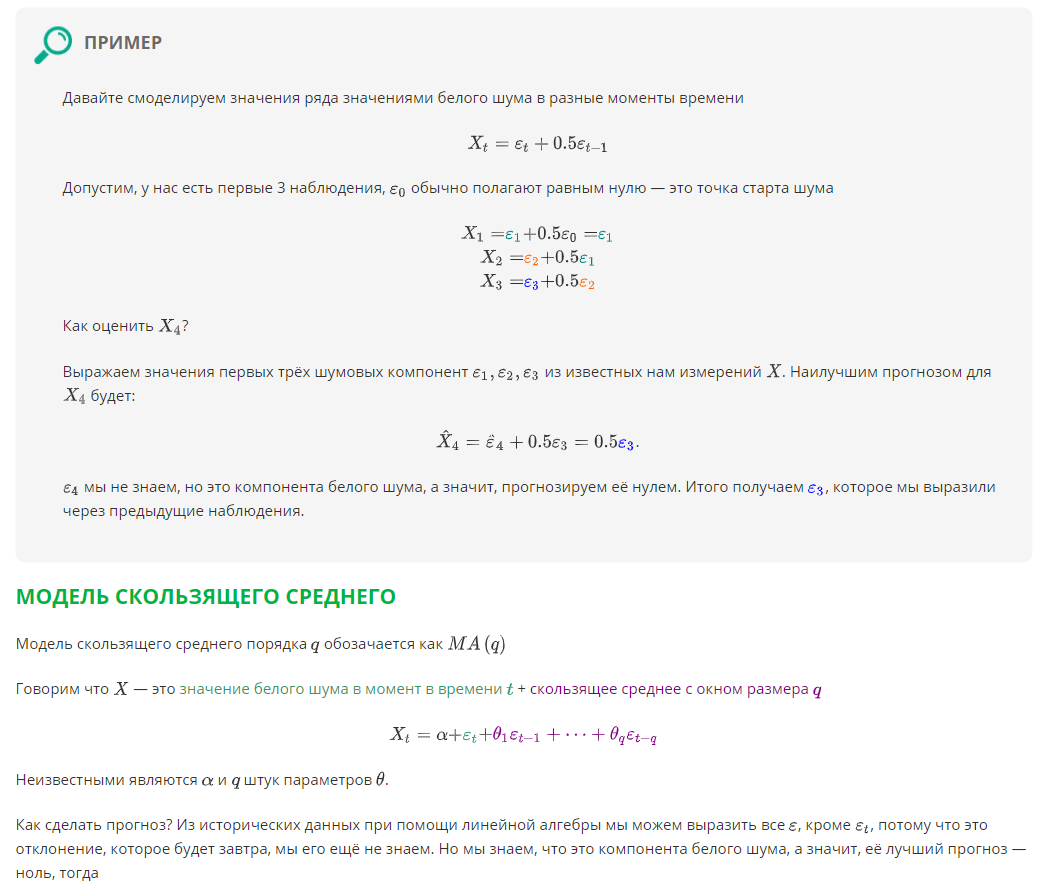

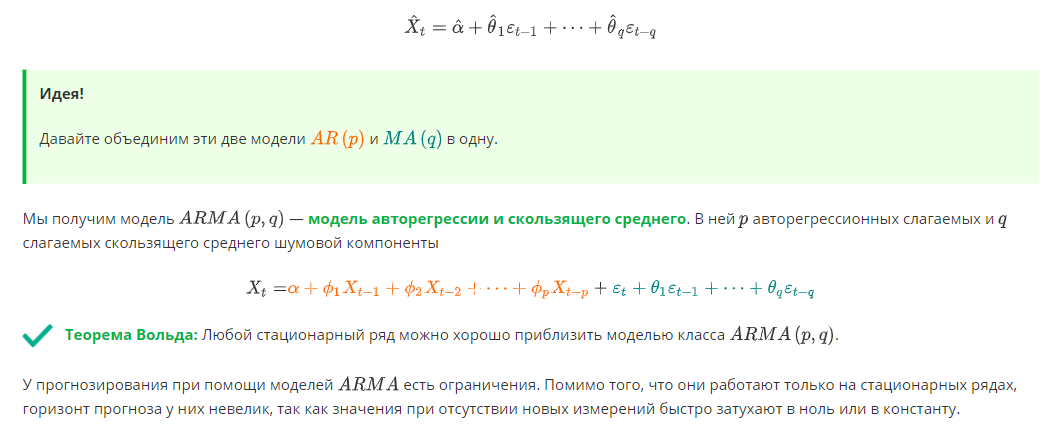

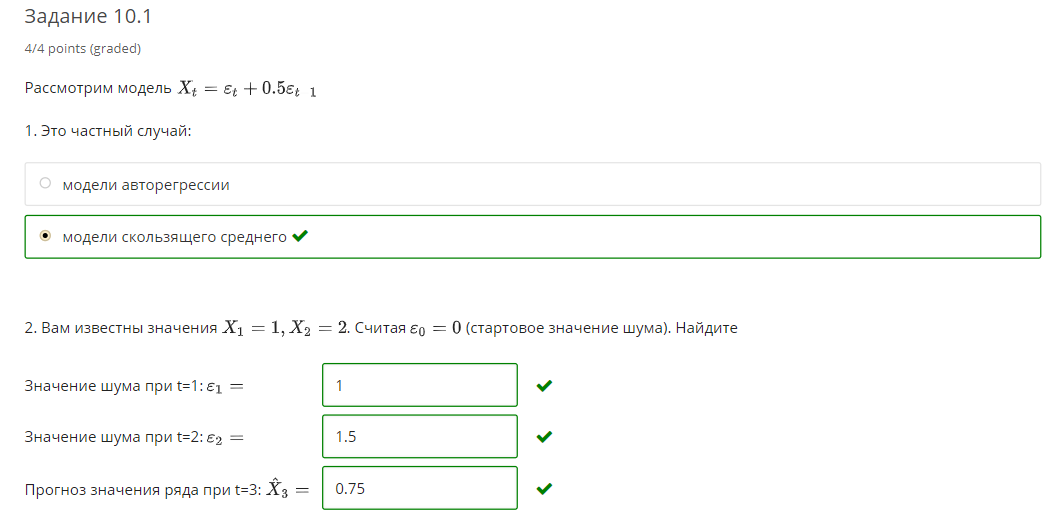

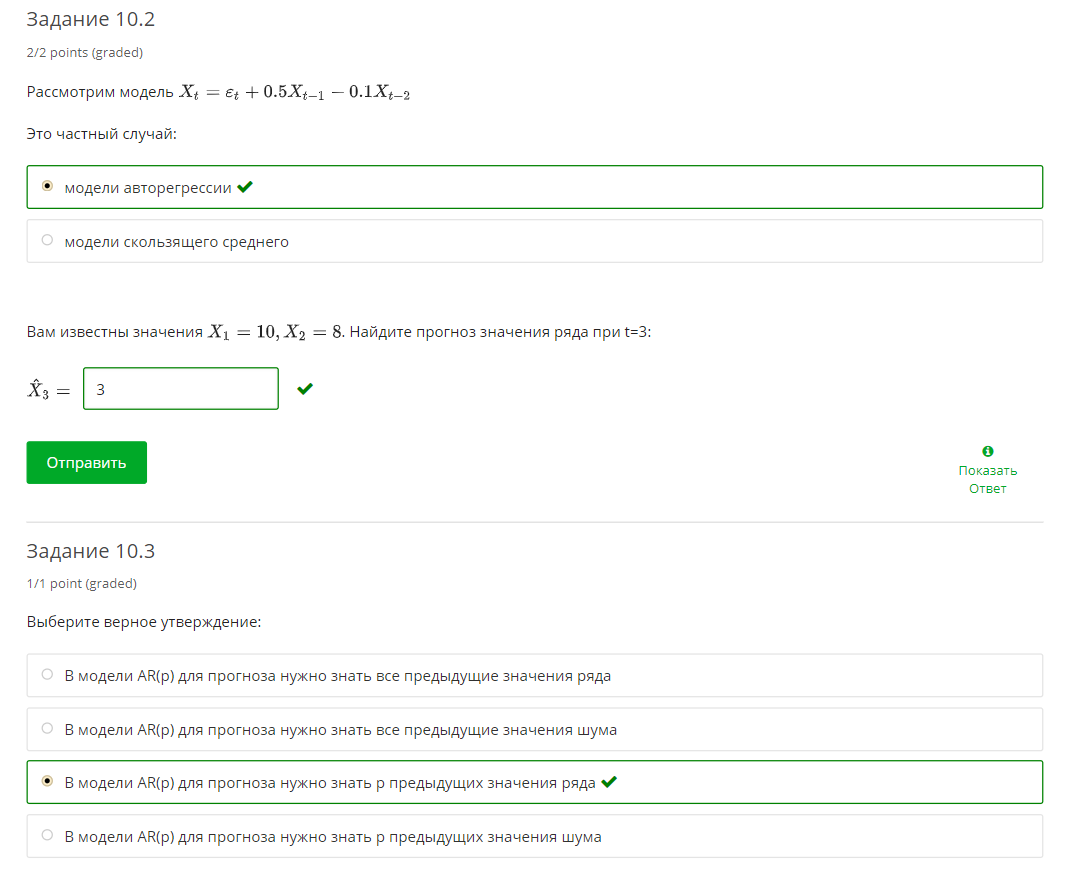

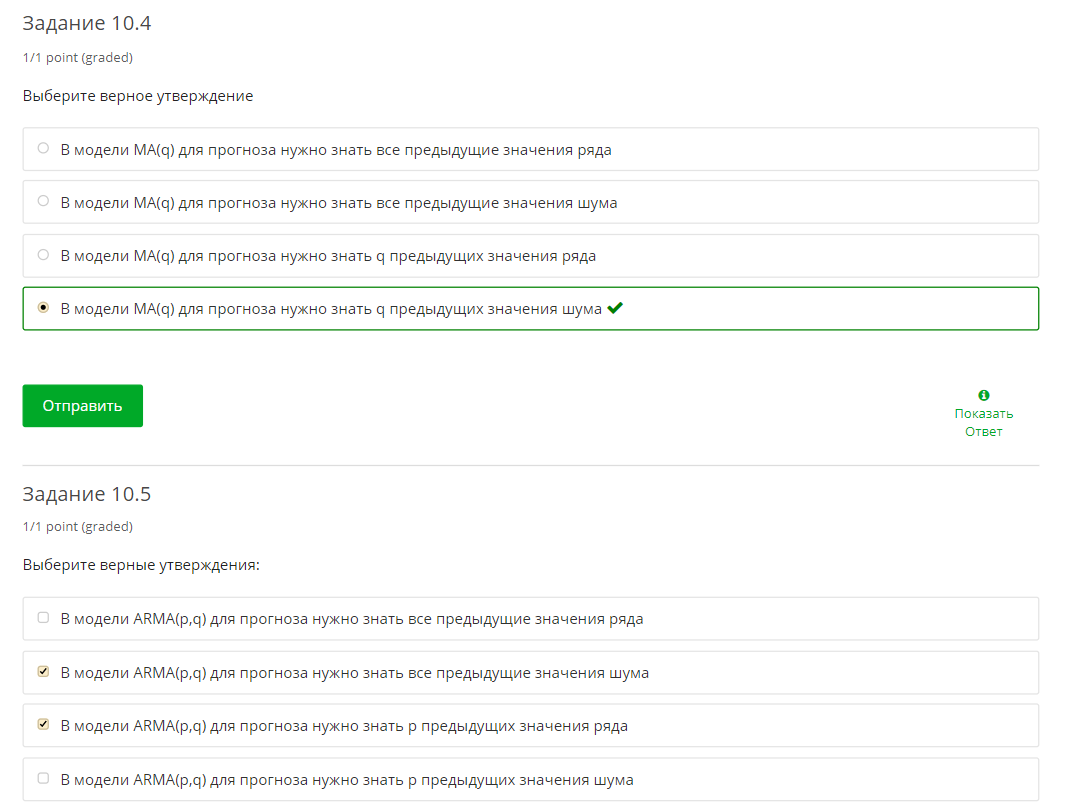

# Модель прогнозирования ARIMA
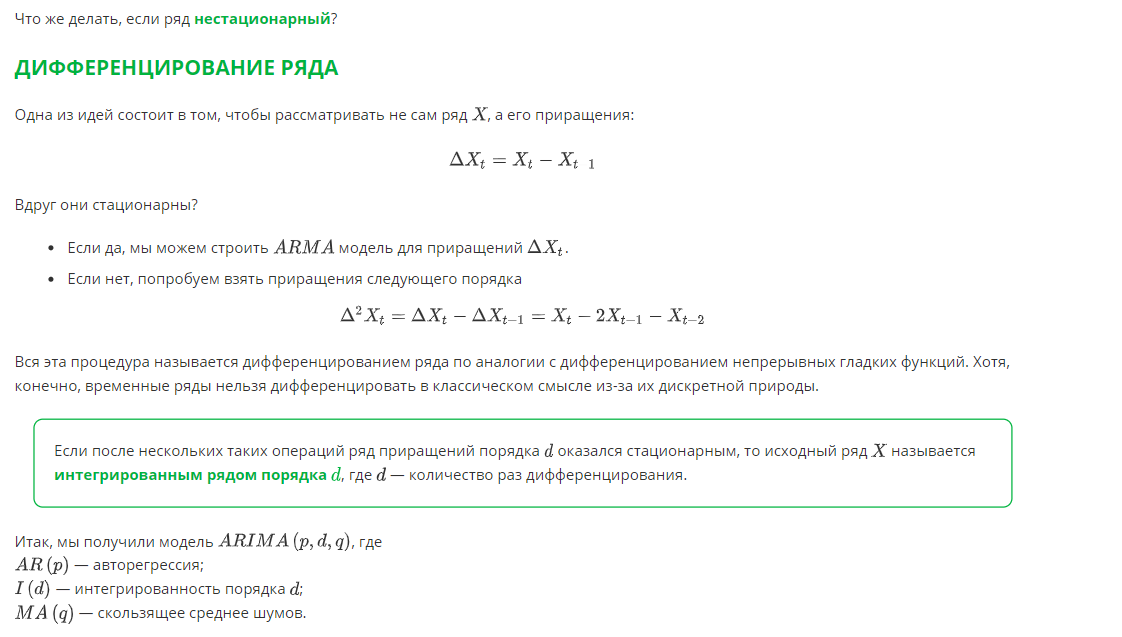

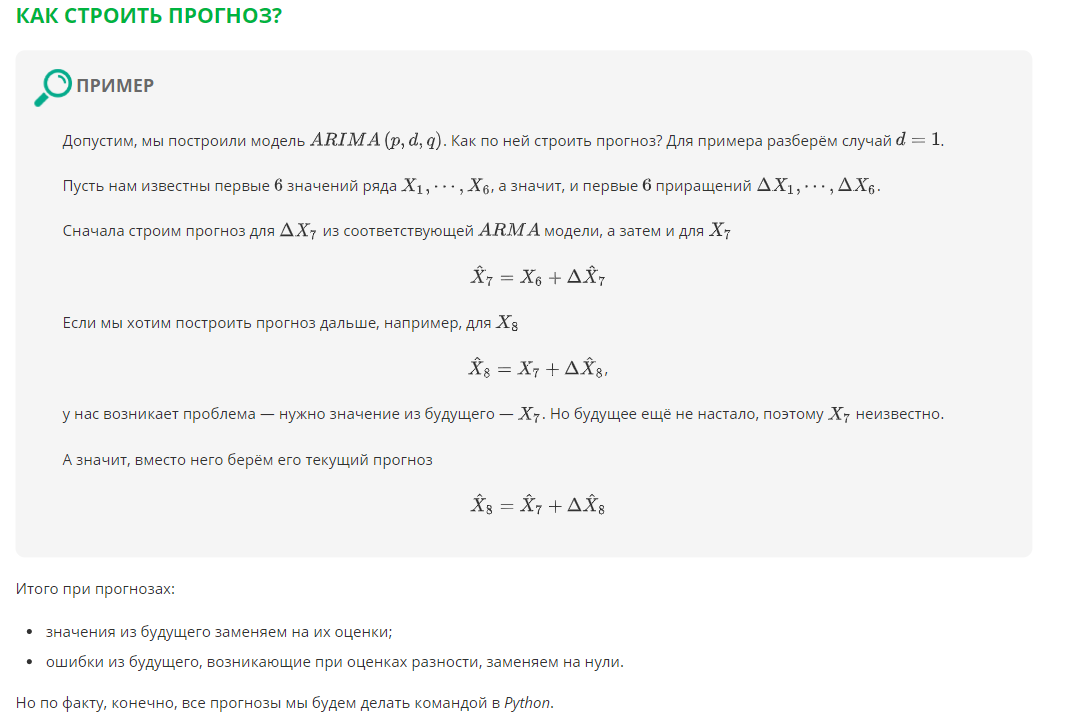

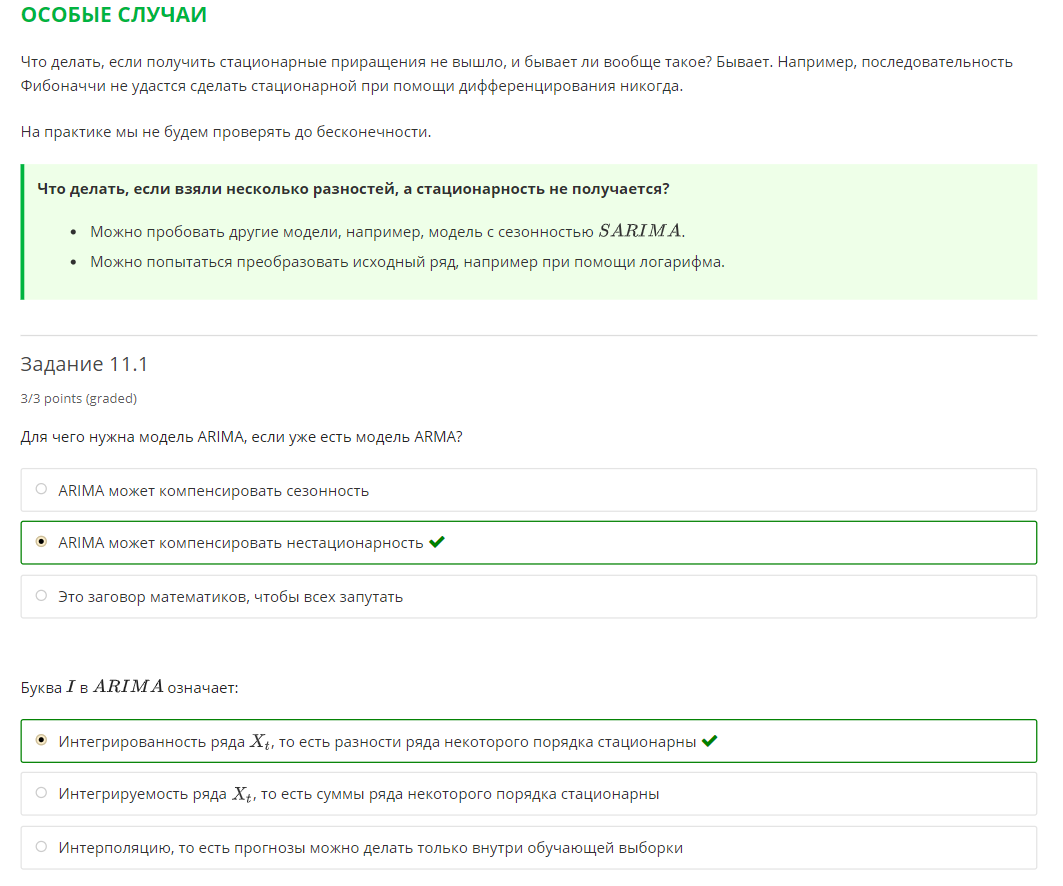

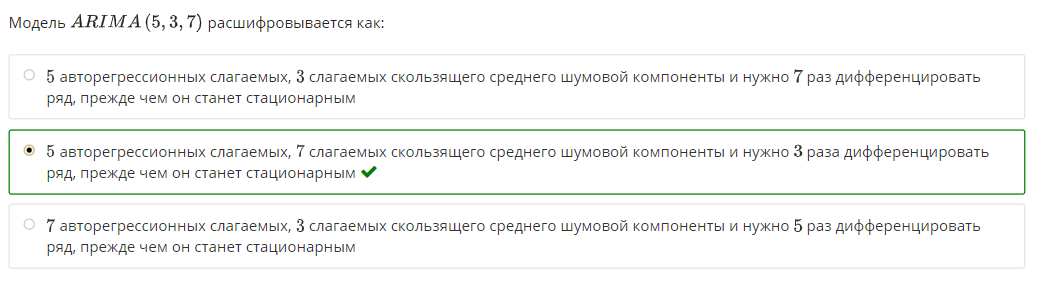

# Автокорреляция и частичная автокорреляция
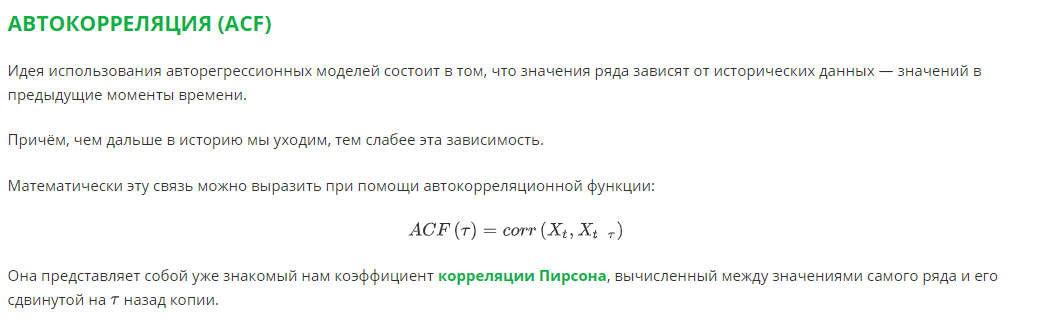

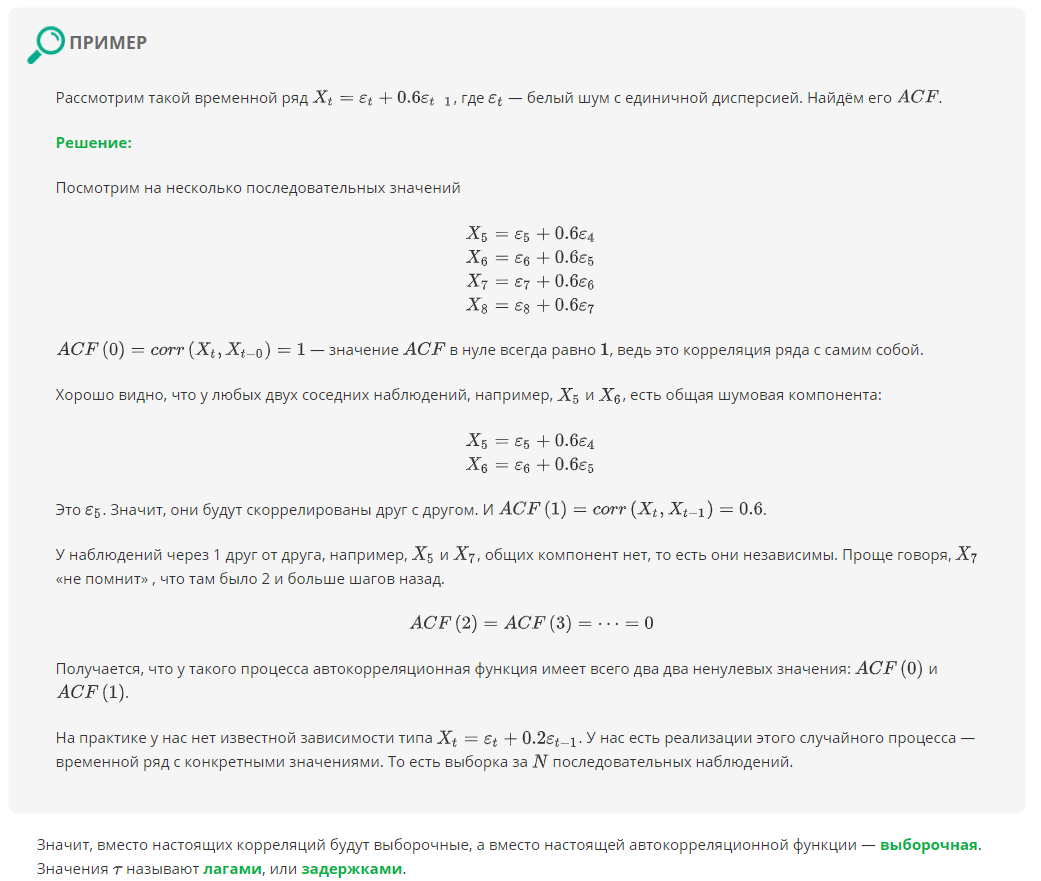

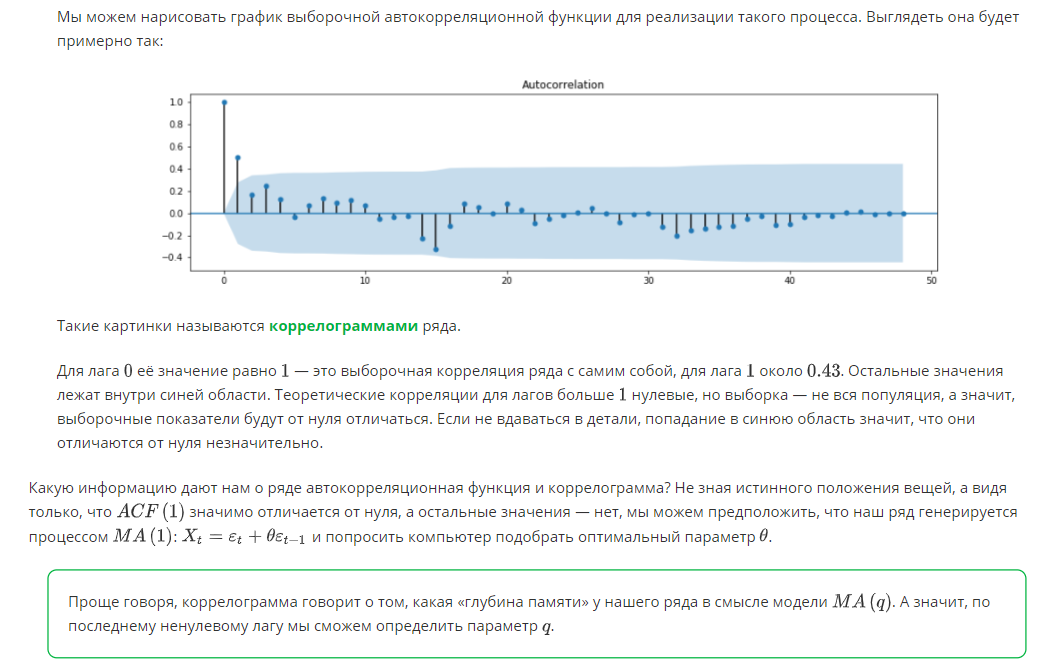

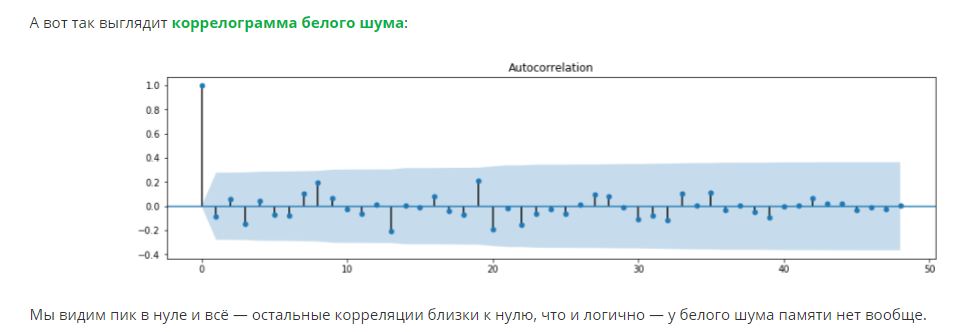

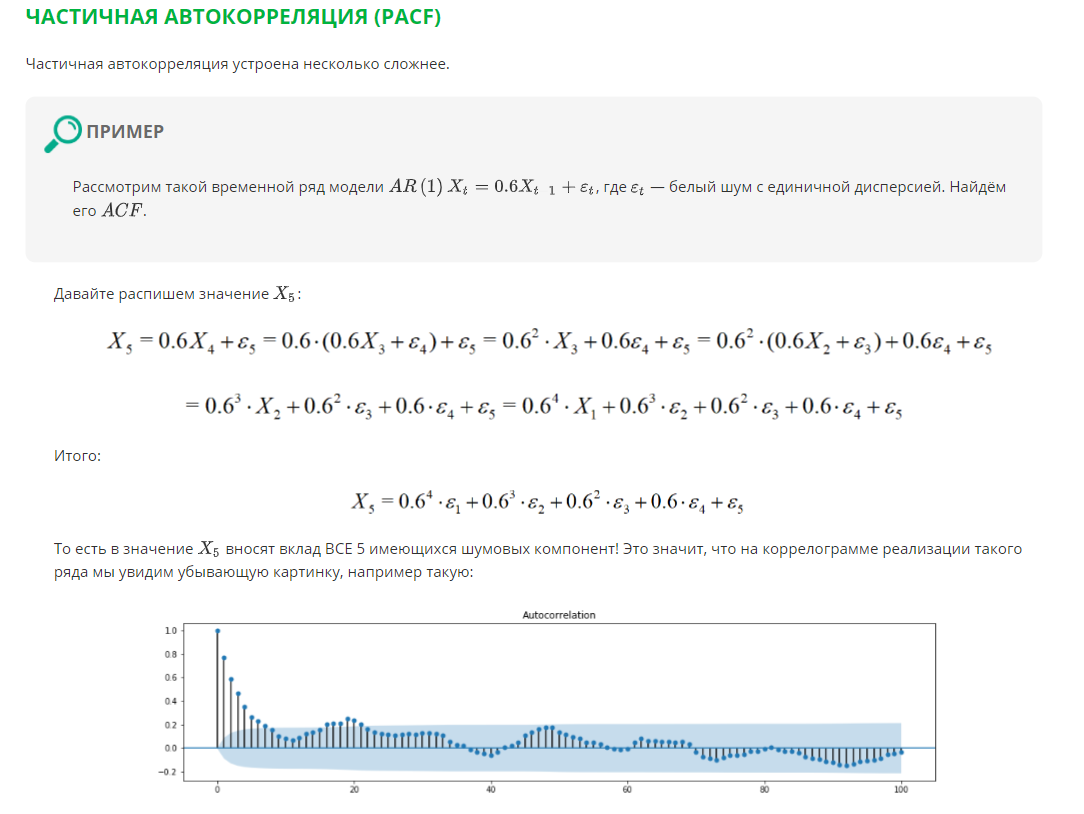

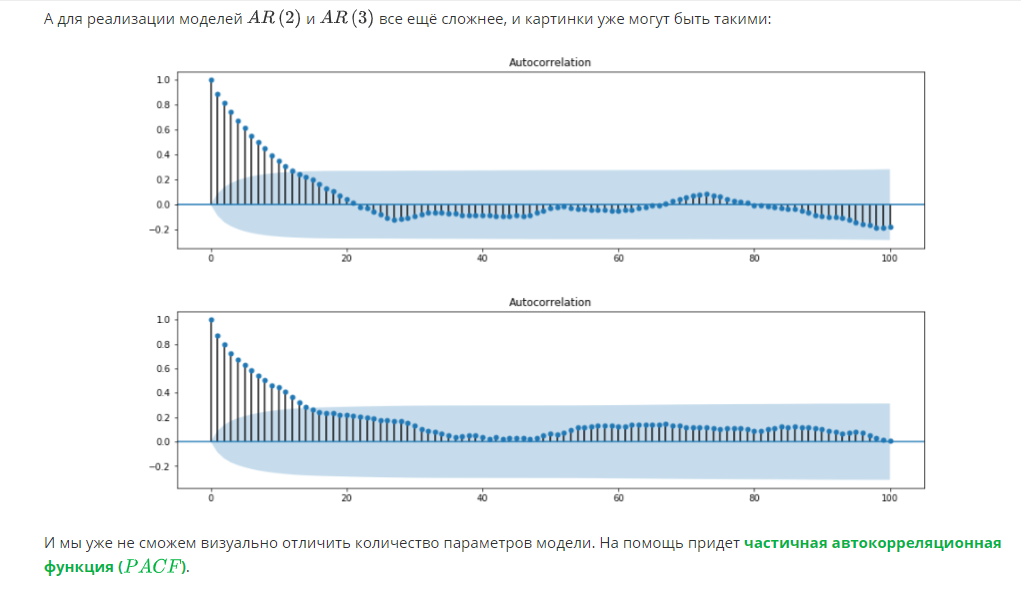

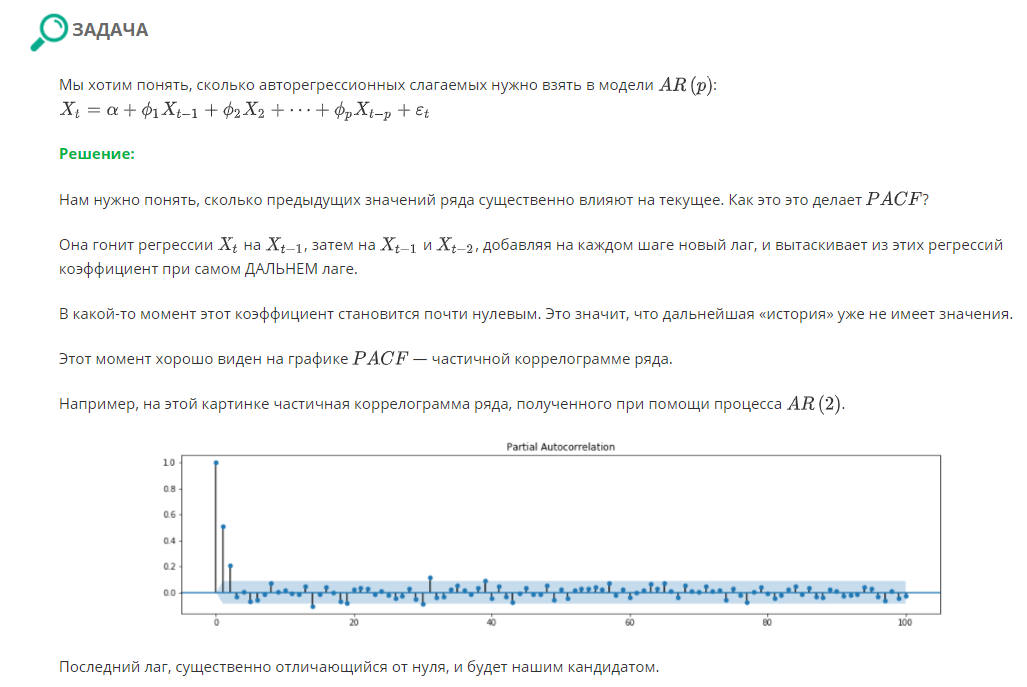

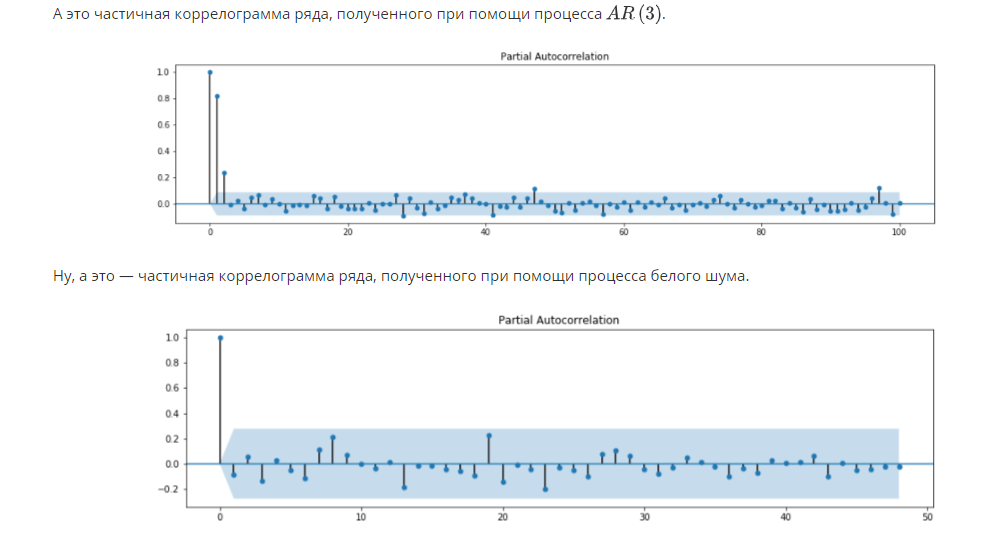

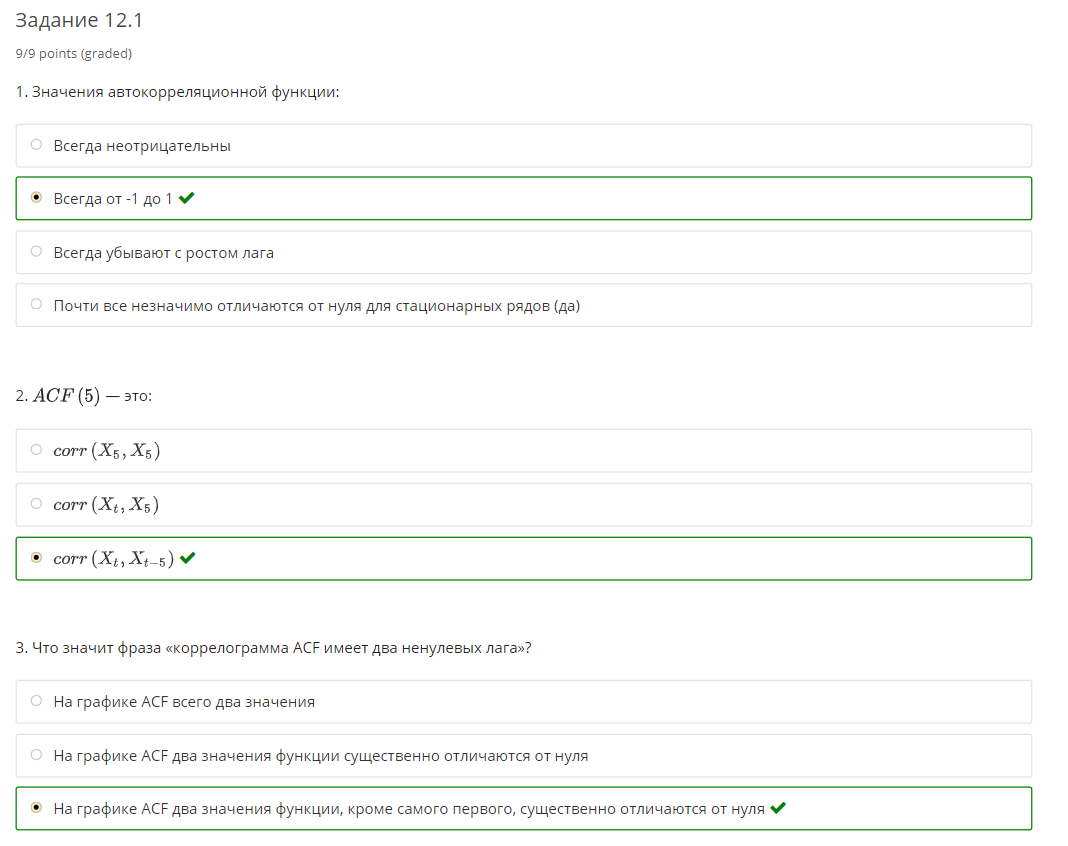

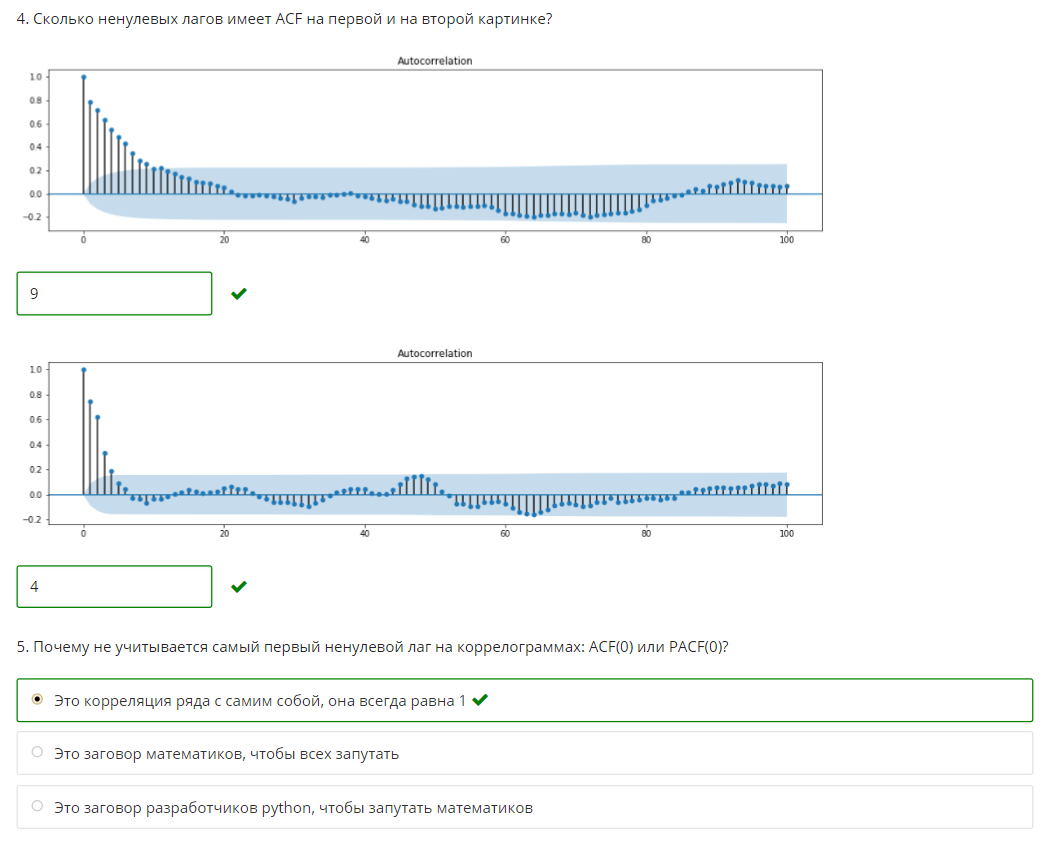

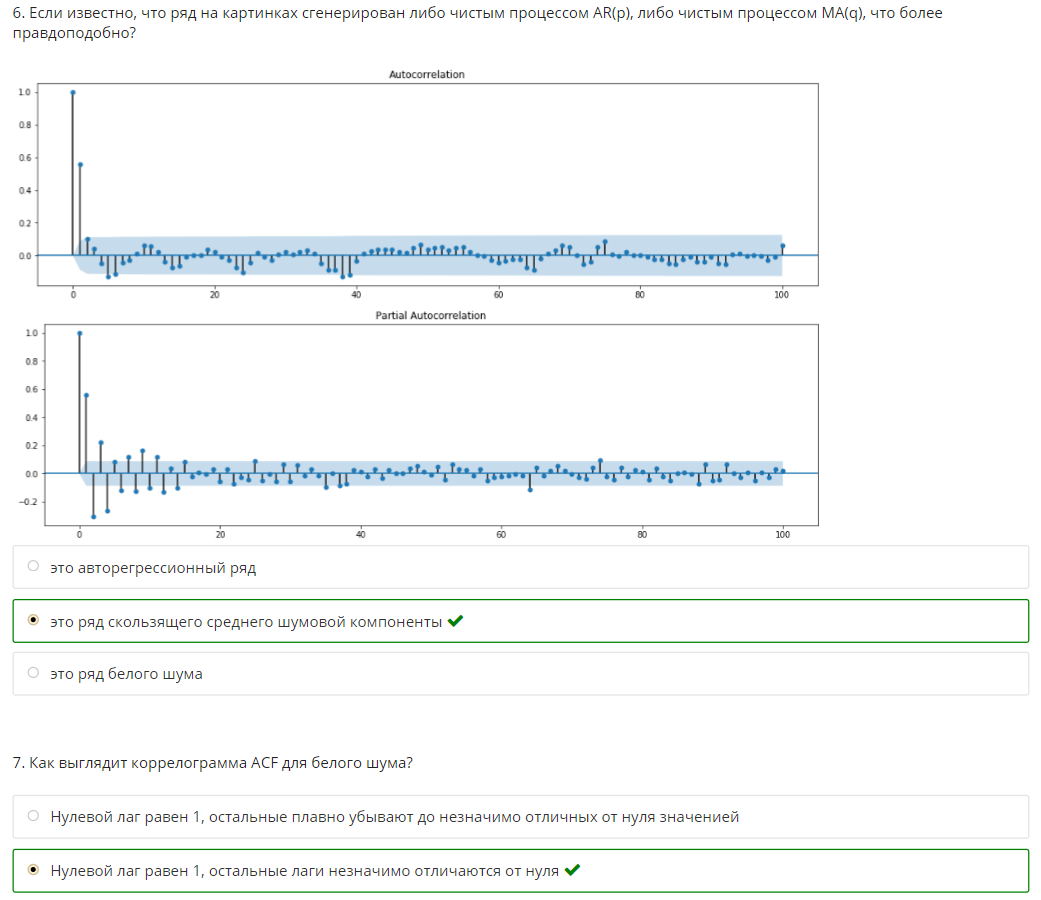

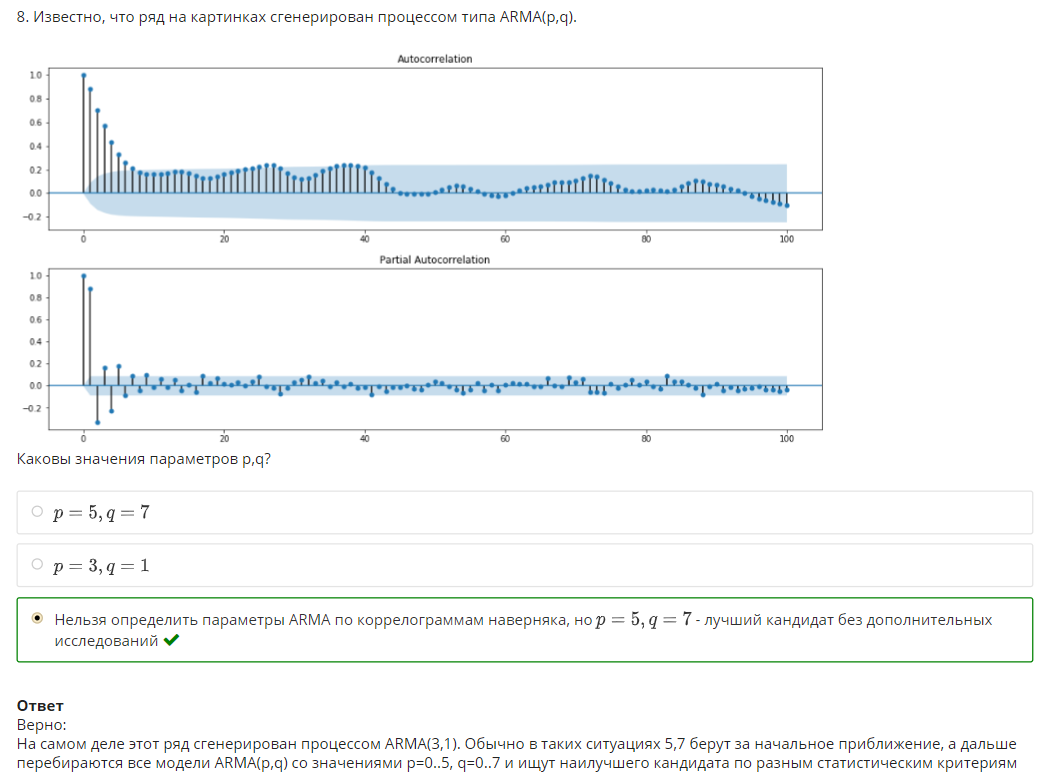

# Практика. ACF и PACF

Создадим функции, которые будут генерировать процессы AR(1), MA(1), AR(2), AR(3), ARMA(2,2) со стандартным нормальным белым шумом

In [50]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt


Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [51]:
# ar геренирует ряд AR(1) без константы с коэффициентом phi

def ar(num,phi):
    eps = np.random.normal(0, 1, size=num)
    walk = np.zeros(num)
    walk[0] = eps[0]
    for i in range (1,num):
        walk[i] = phi*walk[i-1] + eps[i]
    return walk

# ma геренирует ряд MA(1) без константы с коэффициентом theta

def ma(num,theta):
    eps = np.random.normal(0, 1, size=num)
    walk = np.zeros(num)
    walk[0] = eps[0]
    for i in range (1,num):
        walk[i] = theta*eps[i-1] + eps[i]
    return walk

# ar2 геренирует ряд AR(2) без константы с коэффициентами phi1, phi2

def ar2(num,phi1,phi2):
    eps = np.random.normal(0, 1, size=num)
    walk = np.zeros(num)
    walk[0] = eps[0]
    for i in range (1,num):
        walk[i] = phi1*walk[i-1] + phi2*walk[i-2] + eps[i]
    return walk

# ar3 геренирует ряд AR(3) без константы с коэффициентами phi1, phi2, phi3

def ar3(num,phi1,phi2,phi3 ):
    eps = np.random.normal(0, 1, size=num)
    walk = np.zeros(num)
    walk[0] = eps[0]
    for i in range (1,num):
        walk[i] = phi1*walk[i-1] + phi2*walk[i-2] + phi3*walk[3] + eps[i]
    return walk

# arma22 геренирует ряд ARMA(22) без константы с коэффициентами phi1, phi2, theta1, theta2

def arma22(num,phi1,phi2,theta1,theta2 ):
    eps = np.random.normal(0, 1, size=num)
    walk = np.zeros(num)
    walk[0] = eps[0]
    for i in range (1,num):
        walk[i] = phi1*walk[i-1] + phi2*walk[i-2] + eps[i] + theta1*eps[i-1] + theta2*eps[i-2]
    return walk

Сгенерируем процесс MA(1) и нарисуем его график

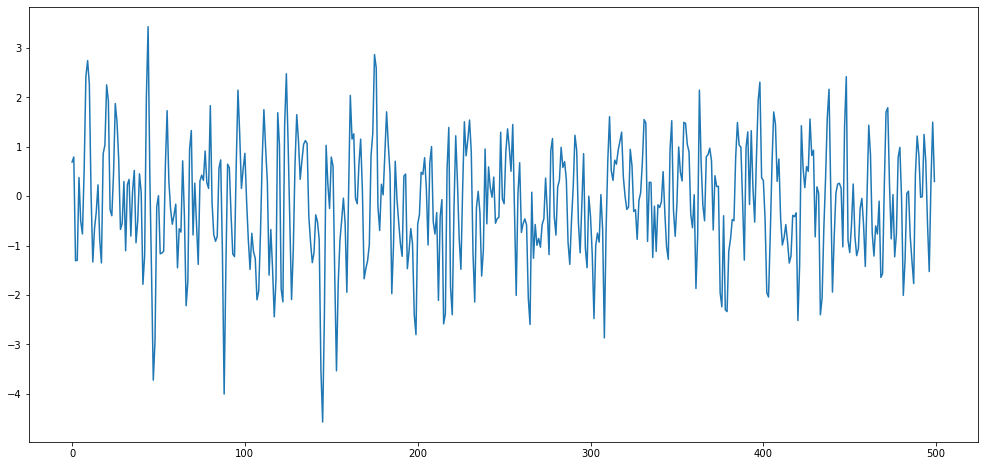

In [52]:
ma1 = ma(500, 0.7)
plt.figure(figsize(17,8))
plt.plot(ma1)

Пример 1 Построим acf и pacf для сгенерированного процесса.

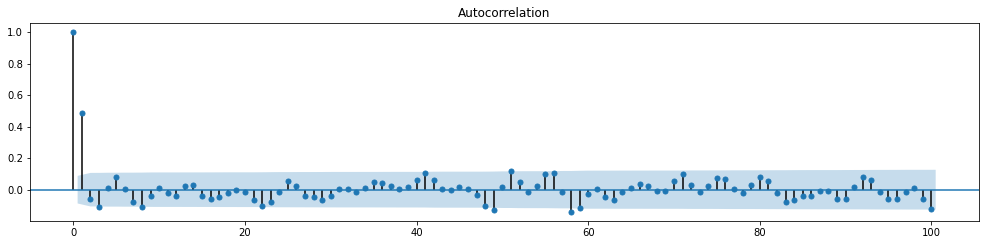

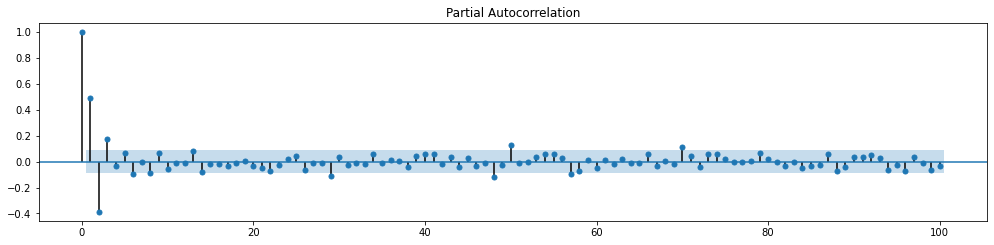

In [53]:
plt.figure(figsize(17,8))
ax = plt.subplot(211)
# tsa.plot_acf рисует коррелограмму acf. lags=100 задает число лагов, для которых строится acf
sm.graphics.tsa.plot_acf(ma1.squeeze(), lags=100, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(ma1.squeeze(), lags=100, ax=ax)
plt.show()

Основная информация о MA модели содержится в ее acf коррелограмме. На ней явно видно, что первый лаг существенно отличается от нуля, а последующие лежат в рамках синей области, то есть их можно с большой уверенностью считать нулями

Пример 2 Сгенерируем процесс белого шума и нарисуем его график

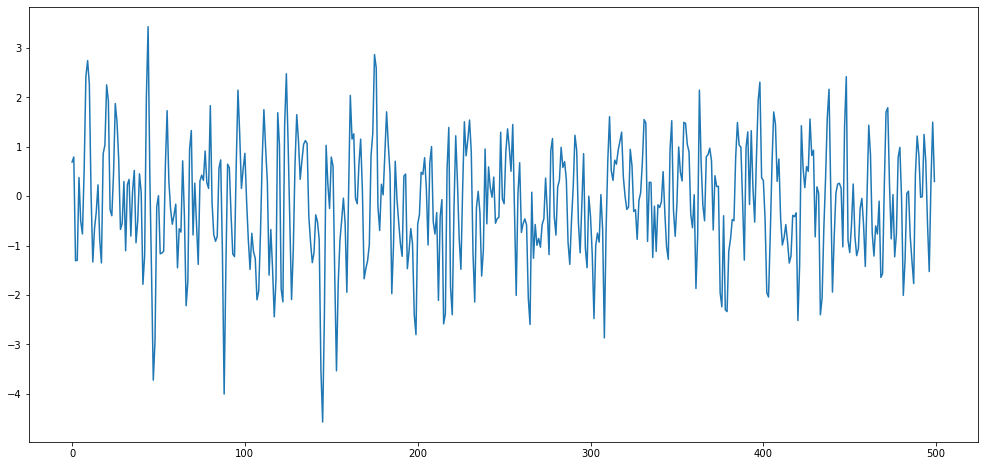

In [54]:
eps = np.random.normal(0, 1, size=500)
plt.plot(ma1)

Визуально процесс белого шума не сильно отличается от MA(1)

Однако на коррелограммах разница заметна:

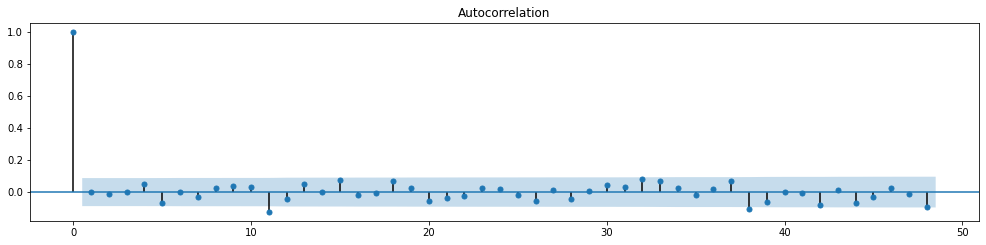

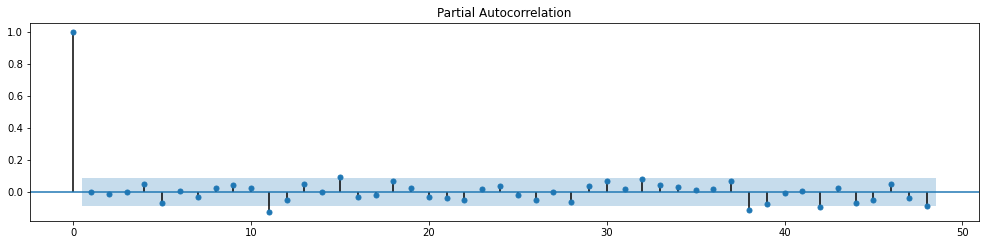

In [55]:
plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(eps.squeeze(), lags=48, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(eps.squeeze(), lags=48, ax=ax)
plt.show()

Как видите, у белого шума нет сущесвенно отличных от нуля лагов на обеих коррелограммах. Это вполне понятно, тк процесс белого шума является совершенно хаотичным

Пример 3

Сгенерируем процесс авторегрессии AR(1) и нарисуем его график

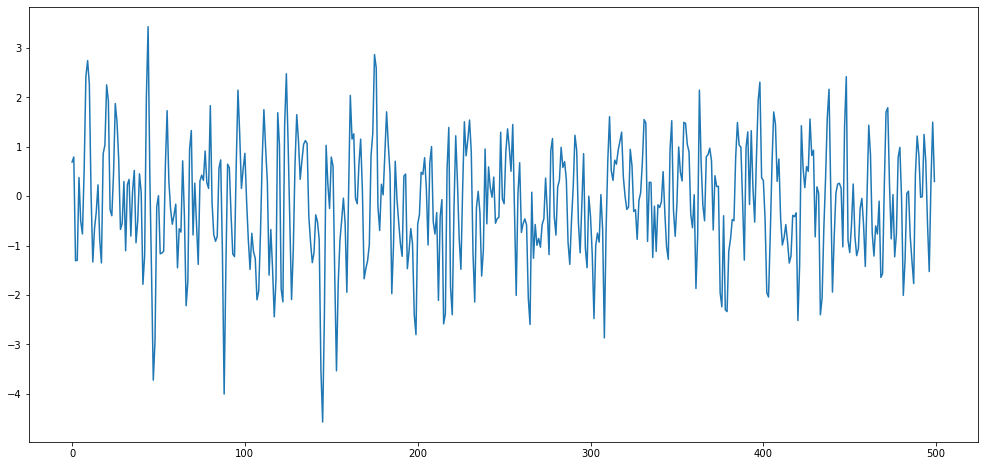

In [57]:
ar1= ar(500, 0.8)
plt.figure(figsize(17,8))
plt.plot(ma1)

Снова сложно отличить это случайное блуждание от белого шума. Давайте посмотрим на коррелограммы

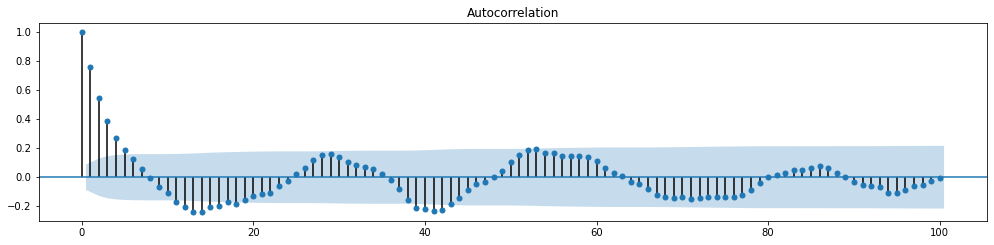

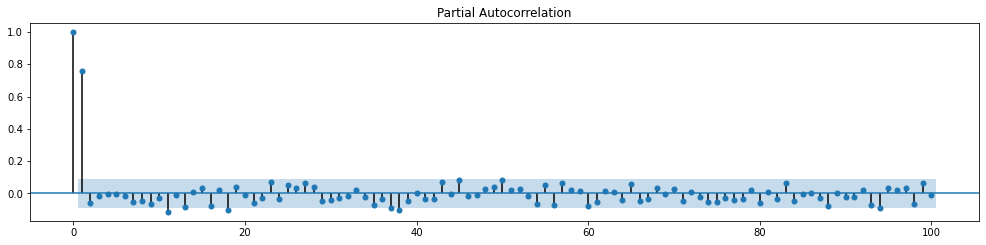

p-value теста Дики-Фуллера: 3.912034441306039e-13


In [58]:
plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(ar1.squeeze(), lags=100, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(ar1.squeeze(), lags=100, ax=ax)
plt.show()
print("p-value теста Дики-Фуллера:",  sm.tsa.stattools.adfuller(ar1)[1])

Коррелограмма ACF типична для процессов типа AR(1). Видим на ней в начале убывание лагов по геометрической прогресии, как и предсказывает нам теория

На частичной коррелограмме PACF мы видим один лаг (первый), сильно отличающийся от нуля.

Пример 4

Сгенерируем процесс авторегрессии AR(2) и AR(3) и нарисуем их коррелограммы

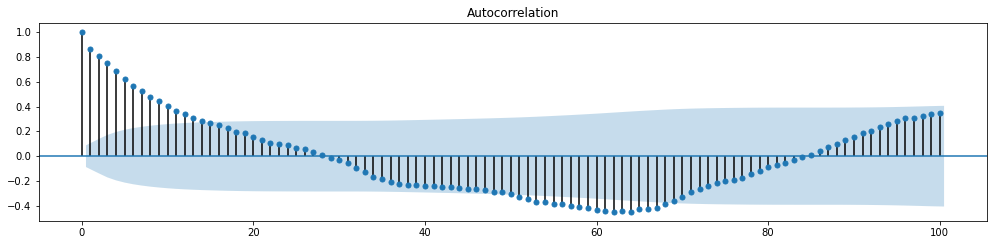

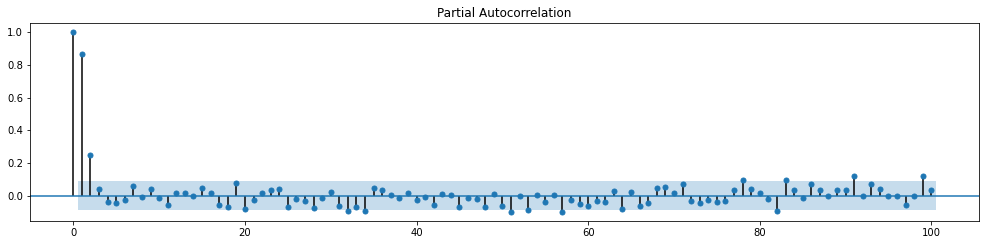

p-value теста Дики-Фуллера: 0.0002219440132799765


In [59]:
ar2_ = ar2(500, 0.7,0.2)
plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(ar2_.squeeze(), lags=100, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(ar2_.squeeze(), lags=100, ax=ax)
plt.show()
print("p-value теста Дики-Фуллера:",  sm.tsa.stattools.adfuller(ar2_)[1])

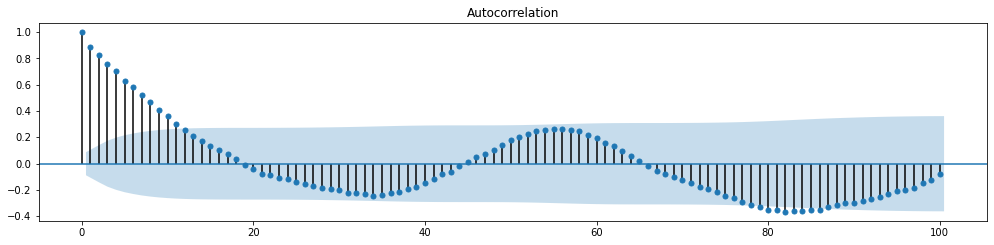

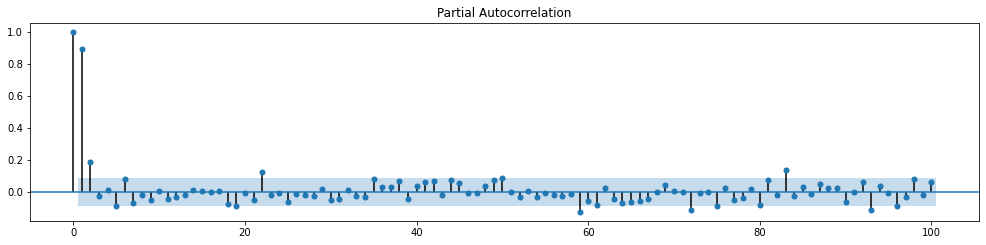

p-value теста Дики-Фуллера: 0.0003723612157705616


In [60]:
ar3_ = ar3(500,0.7,0.2,-0.1)
plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(ar3_.squeeze(), lags=100, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(ar3_.squeeze(), lags=100, ax=ax)
plt.show()
print("p-value теста Дики-Фуллера:",  sm.tsa.stattools.adfuller(ar3_ )[1])

Снова типичная картинка ACF для AR(p) процессов - экспоненциальное (т.е. по геометрической прогрессии) убывание лагов

Пример 5

Давайте посмотрим, как выглядят коррелограммы нестационарных рядов.

Сгенерируем случайное блуждание с коэффициентом 1

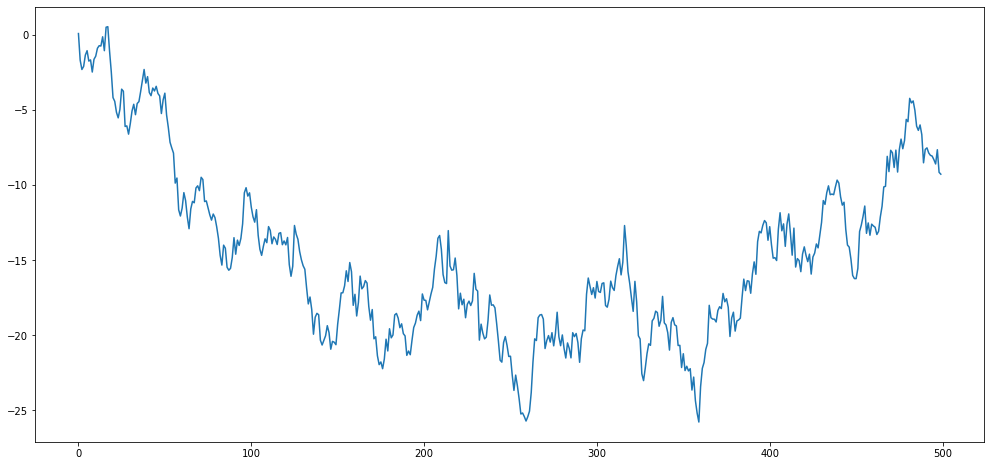

In [61]:
ar_n = ar(500,1)
plt.plot(ar_n)

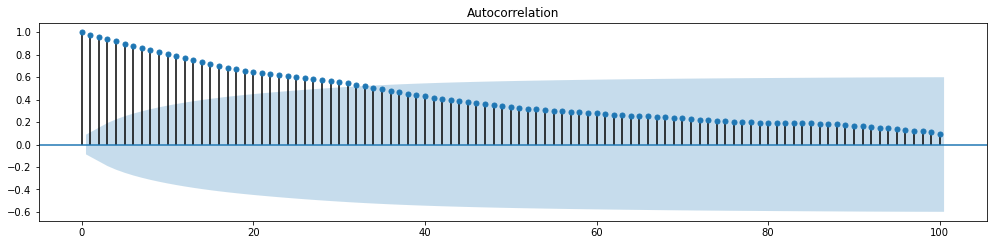

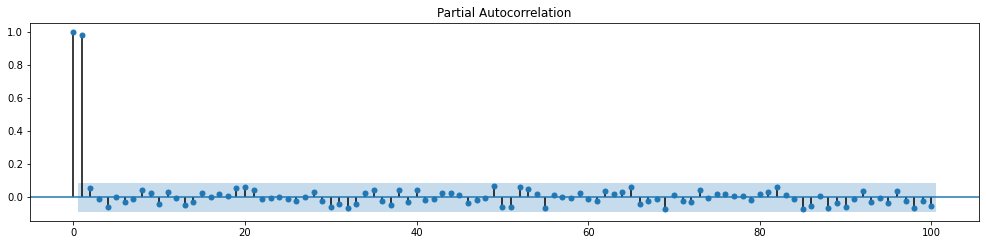

p-value теста Дики-Фуллера: 0.08106013358082298


In [62]:
plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(ar_n.squeeze(), lags=100, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(ar_n.squeeze(), lags=100, ax=ax)
plt.show()
print("p-value теста Дики-Фуллера:",  sm.tsa.stattools.adfuller(ar_n )[1])

Ряд имеет ярко выраженный (хоть и случайный) тренд. Это сказывается на его ACF коррелограмме - автокорреляции завышены

На частичной коррелограмме (PACF) видим один отличный от нуля лаг - первый

Пример 6

Сгенерируем ряд ARMA(2,2) и посмотрим на его коррелограммы. Для комбинированных моделей ARMA(p,q) коррелограммы могут некорректно отражать количество параметров

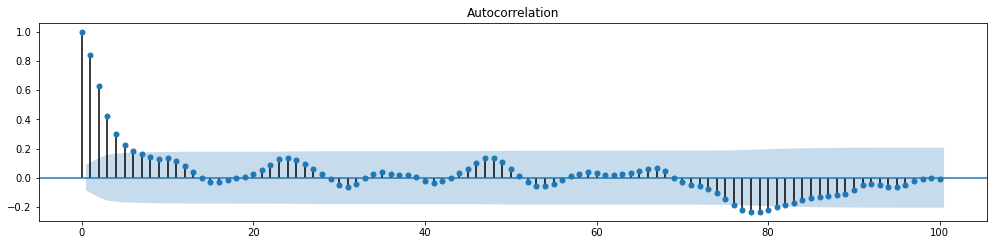

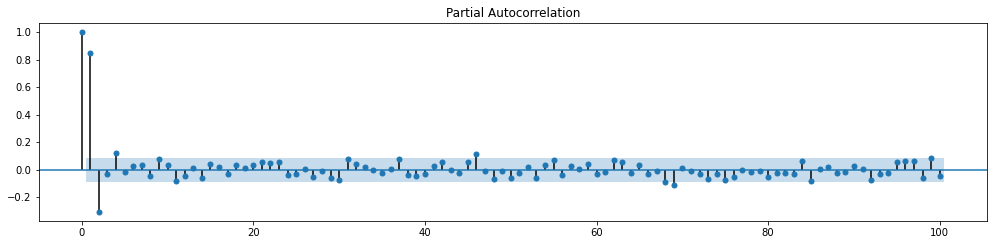

In [63]:
arma = arma22(500,0.5,0.2,0.6,0.3)
plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(arma.squeeze(), lags=100, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(arma.squeeze(), lags=100, ax=ax)
plt.show()

Пример 7

Нарисуем коррелограммы для конфетного временного ряда

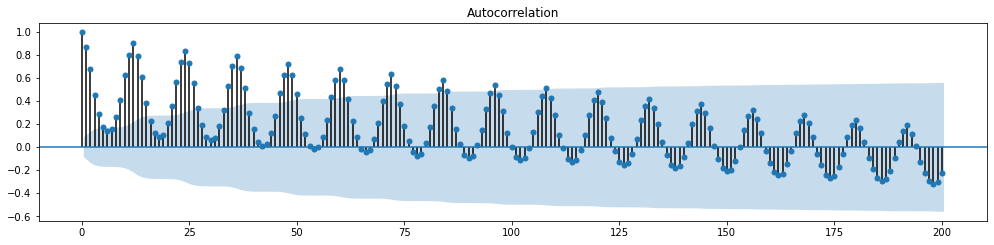

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


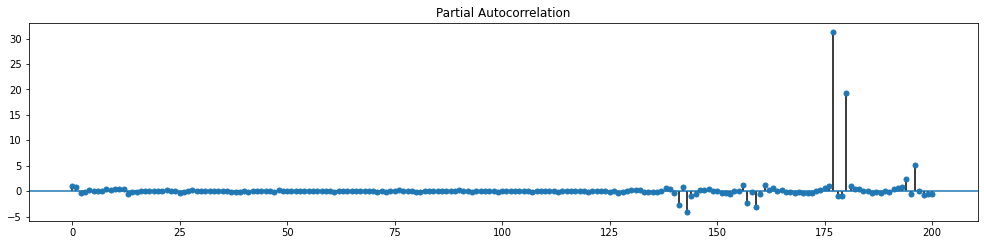

Критерий Дики-Фуллера: p=0.338178


In [65]:
df = pd.read_csv('candy_production.csv')
df['observation_date'] = pd.to_datetime(df['observation_date'], format = '%Y-%m-%d')
df = df.set_index(pd.DatetimeIndex(df['observation_date']))
df.drop(['observation_date'], axis =1, inplace = True)
candy=df.IPG3113N
plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(candy.squeeze(), lags=200, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(candy.squeeze(), lags=200, ax=ax)
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(candy)[1])

Обратите внимание на ACF - именно так выглядит комбинация тренда и сезонности. Тренд сдвигает значения корреляций вверх, а сезонность добавляет колебания с постоянным (это важно!) периодом

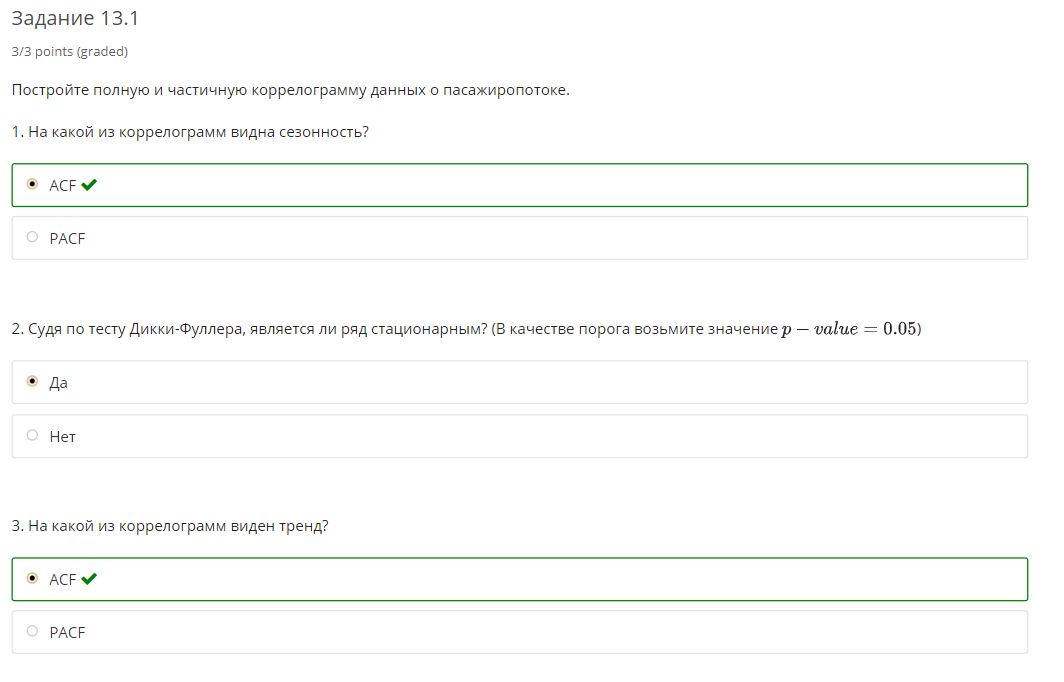

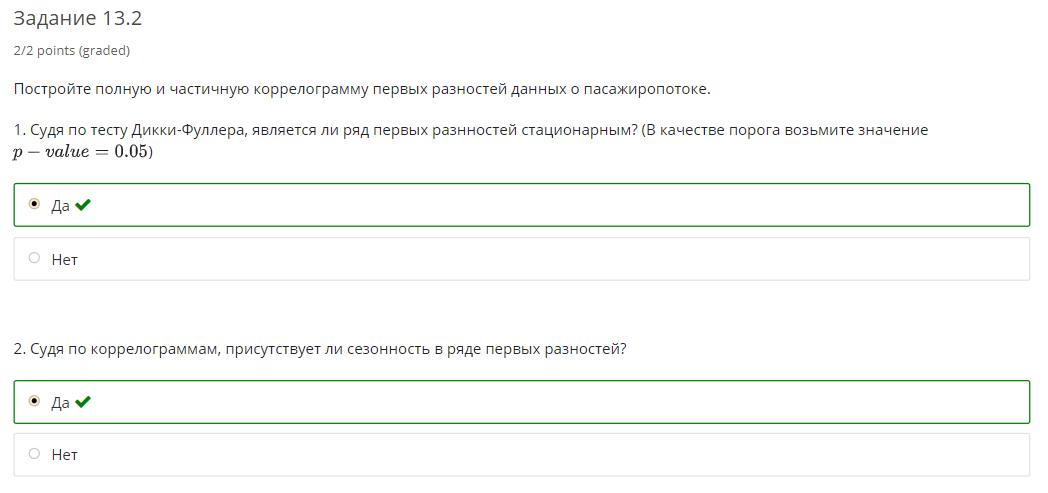

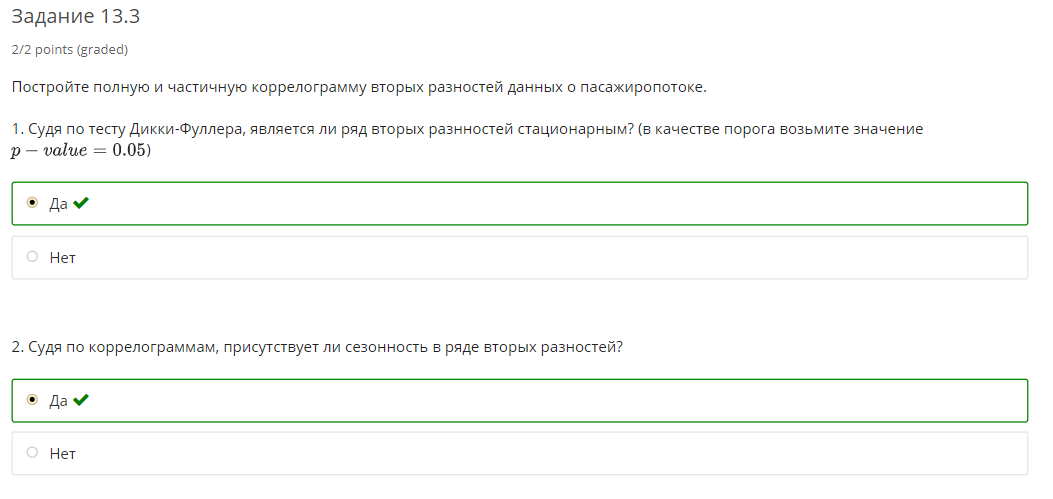

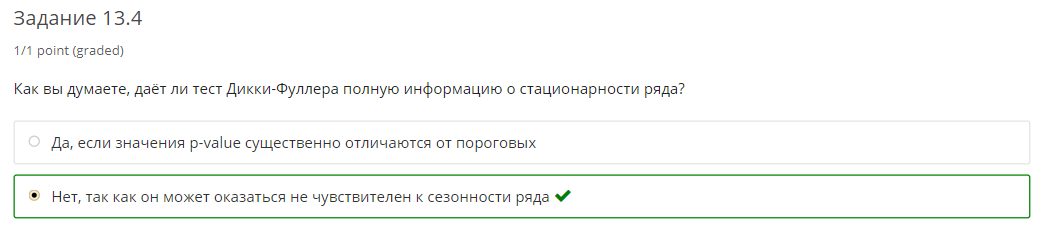

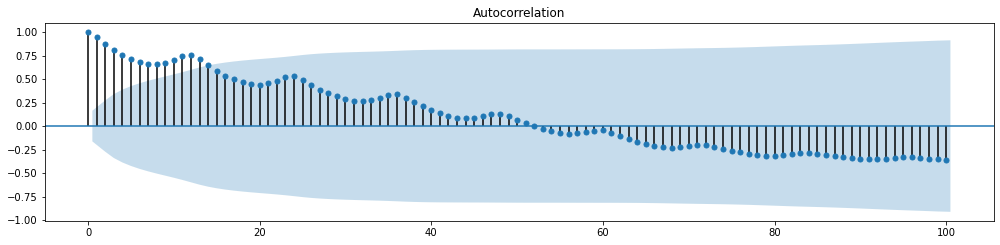

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


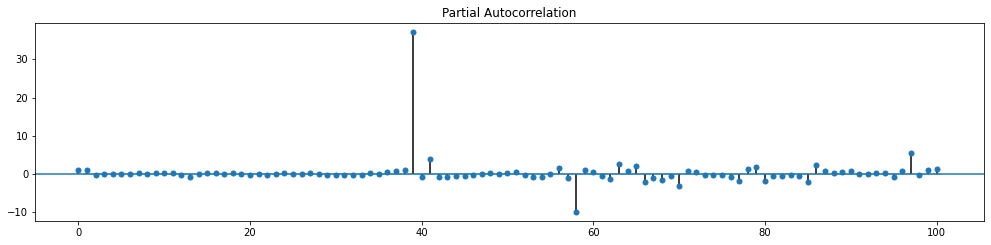

Критерий Дики-Фуллера: p=0.991880


In [67]:
df_2 = pd.read_csv('AirPassengers.csv')

df_2['Month'] = pd.to_datetime(df_2['Month'], format = '%Y-%m')
df_2 = df_2.set_index(pd.DatetimeIndex(df_2['Month']))
df_2.drop(['Month'], axis =1, inplace = True)
passengers=df_2['#Passengers']
plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(passengers.squeeze(), lags=100, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(passengers.squeeze(), lags=100, ax=ax)
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(passengers)[1])

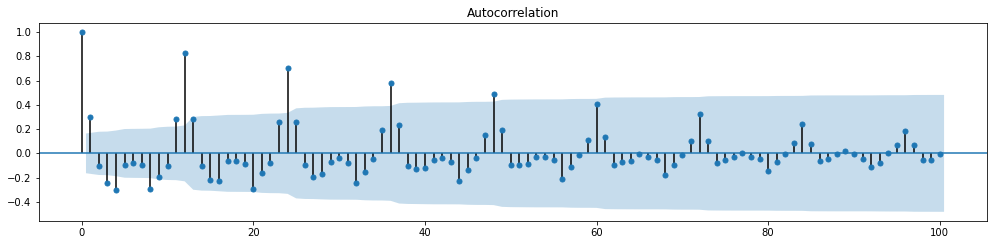

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


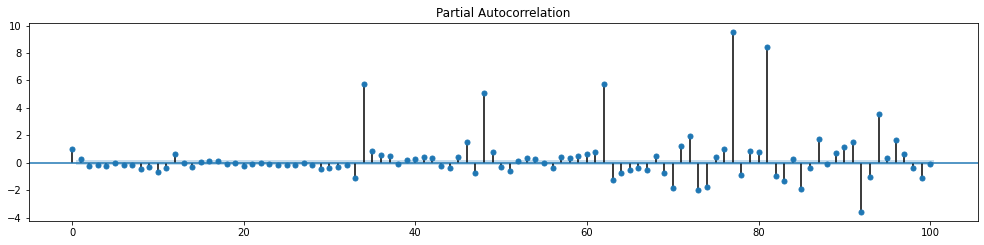

Критерий Дики-Фуллера: p=0.046620


In [69]:
first_diff = passengers.diff()

plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(first_diff.dropna().squeeze(), lags=100, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(first_diff.dropna().squeeze(), lags=100, ax=ax)
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(first_diff.fillna(0))[1])

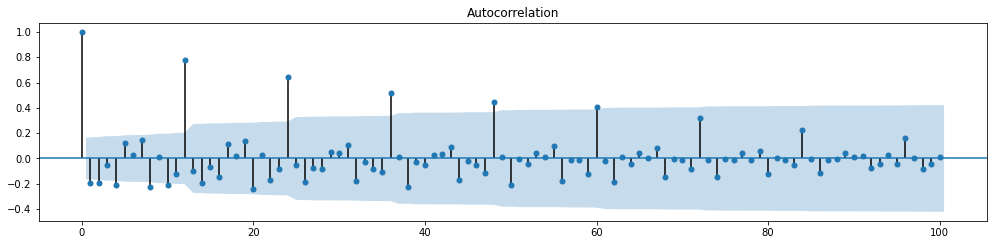

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


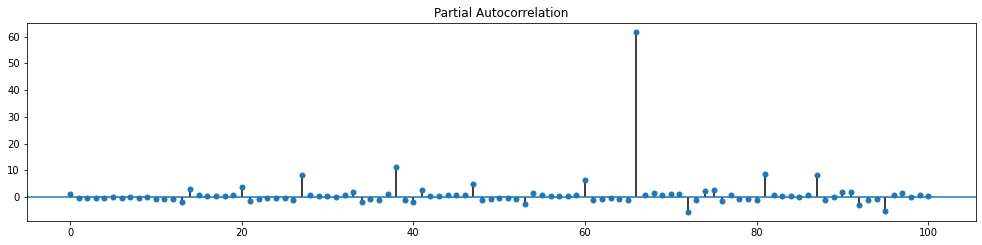

Критерий Дики-Фуллера: p=0.000000


In [70]:
second_diff = first_diff.diff()

plt.figure(figsize(17,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(second_diff.dropna().squeeze(), lags=100, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(second_diff.dropna().squeeze(), lags=100, ax=ax)
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(second_diff.fillna(0))[1])

# Подбор коэффициентов для ARIMA
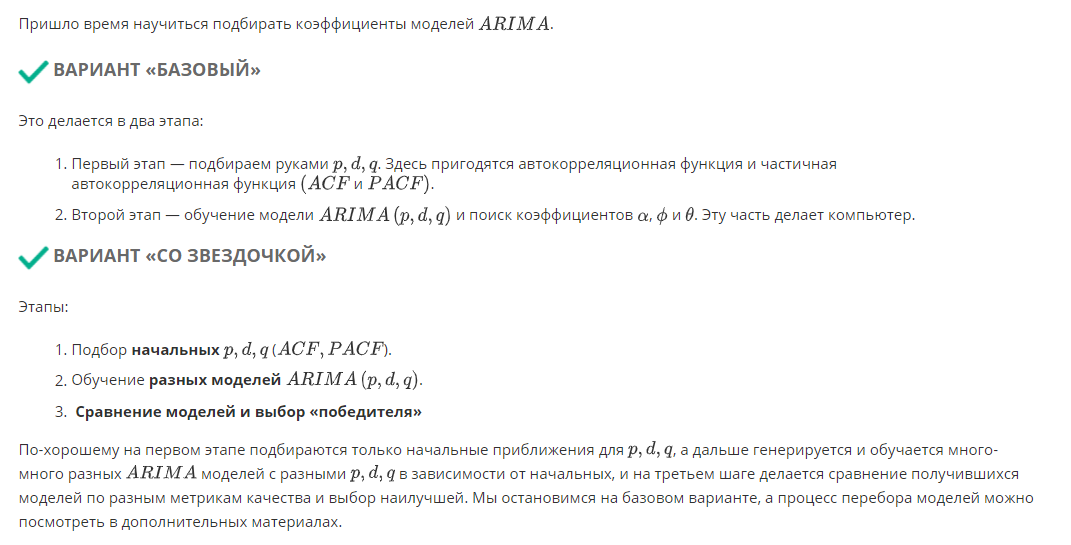

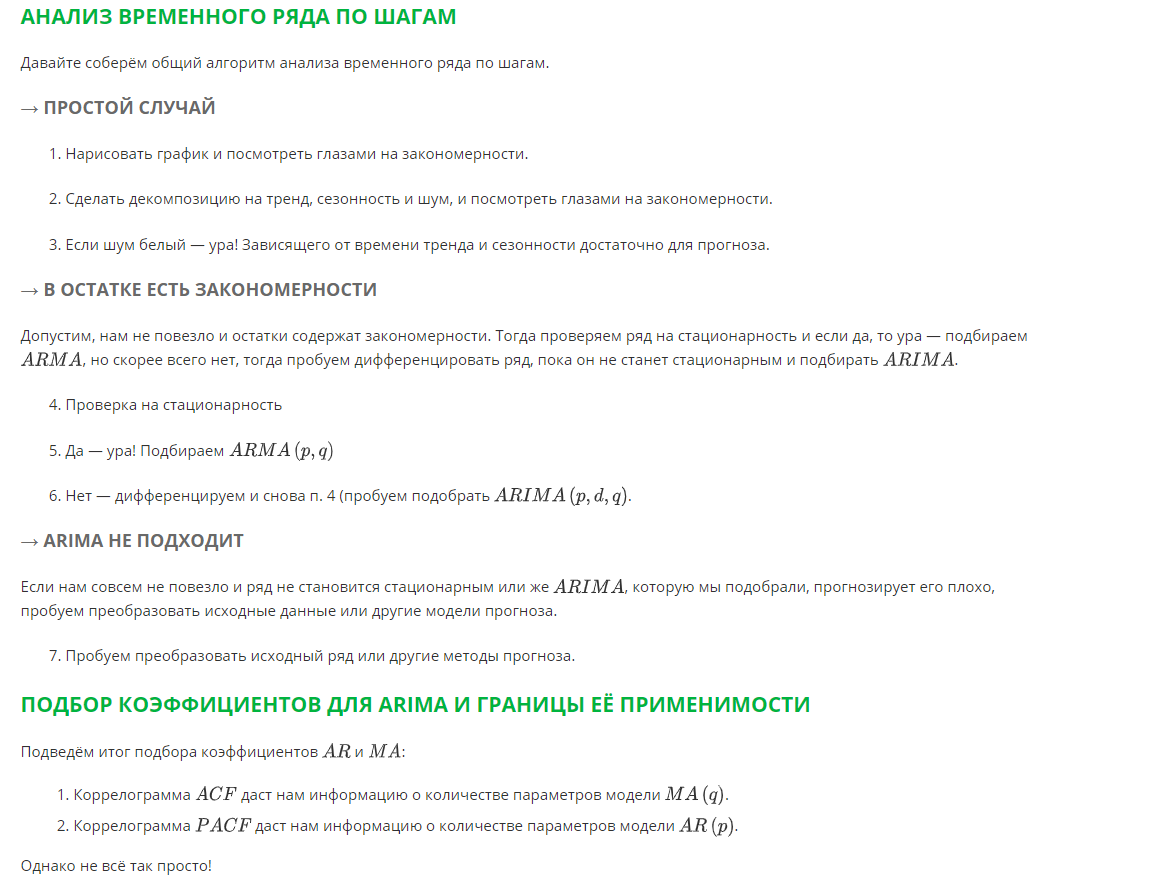

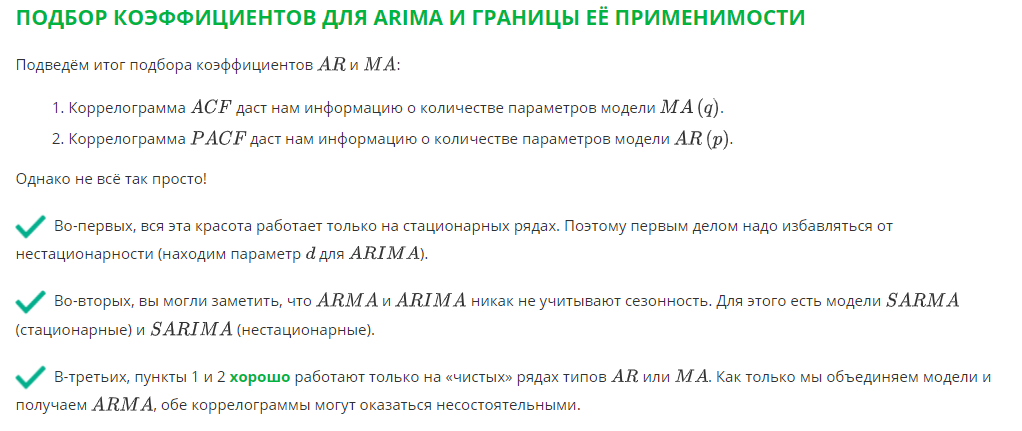

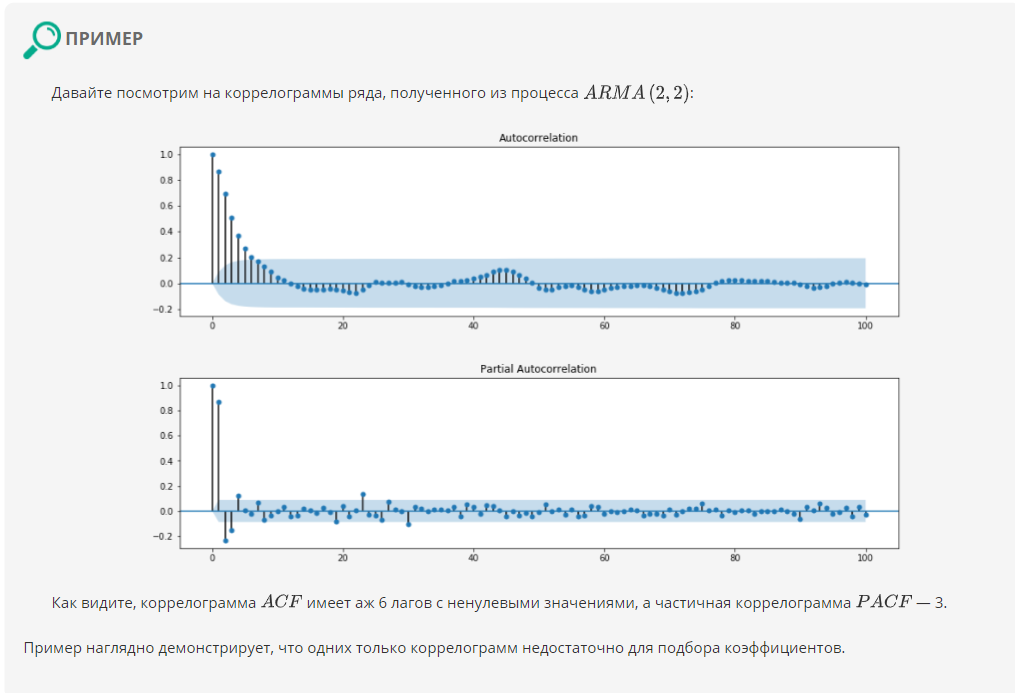

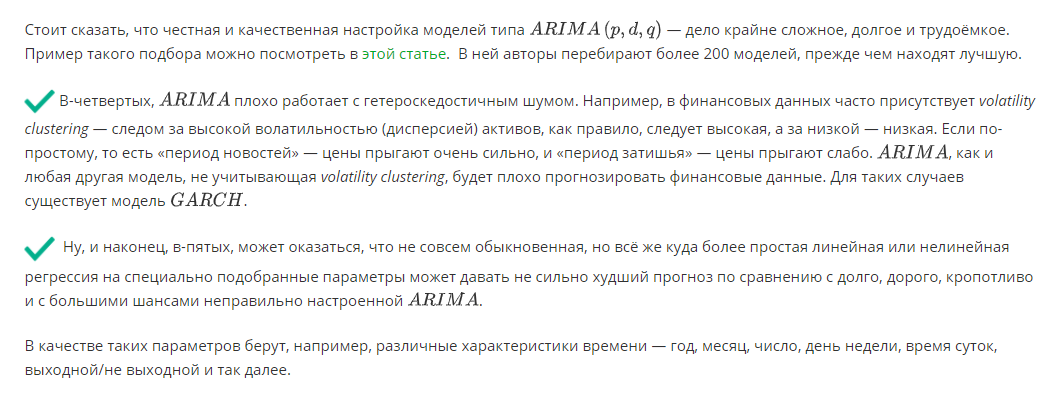

# Дополнительные материалы

В качестве дополнительной литературы рекомендуем вам прочесть [о разных способах построить линейную регрессию в Python.](https://habr.com/ru/post/279117/)

[Подробнее о скользящем среднем и другим методах сглаживания ряда в этой статье](https://habr.com/ru/company/ods/blog/327242/). В ней также можно у знать о кроссвалидации.

В качестве дополнительной литературы рекомендуем вам прочесть статью [«Скользящие средние. Часть 1 — теория».](https://av-finance.ru/texnicheskij-analiz/skolzyashhie-srednie-chast-1-teoriya.html)

Также вам будет интересна статья [про использование скользящих средних в трейдинге.](https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp)

изучить статью [«Stationarity in time series analysis»](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322)

[Прочесть о Гипотезе случайных блужданий для моделей рынка](https://habr.com/ru/company/iticapital/blog/280954/)
освоить [примеры](http://www.hi-edu.ru/e-books/xbook732/files/lect/ver_dop3.pdf) стационарных случайных процессов

[Пример](https://www.8host.com/blog/prognozirovanie-vremennyx-ryadov-s-pomoshhyu-arima-v-python-3/) подбора сезонной модели , показывающий, почему не очень здорово подбирать коэффициенты  «на глазок». Рекомендуем подумать, какие свойства ряда не учёл при подборе модели автор, а затем почитать [комментарии](https://habr.com/ru/post/207160/).